### Assumptions/Comments


- The Tests seen in this file show the results of the binary classification. 5 class classification was also completed, however, the results are not shown here. They are presented in the report
- Only those models were evaluated which gave us the highest accuracies.
- Sometimes PCA was performed before the hyper parameter optimization. This was only for initial test purposes. you can ignore this
- Alot more EDA and cleaning could be done, but we chose to move on in order to finish the deliverable.

# Table of Contents

1.   [Audio Data](#audio)
    1. [EDA](#expaudio)
    1. [MFCC extraction and cleaning](#mfcc)
    1. [Bonus Modeling: Sentiment Classification using Spectrogram images](#spectrogram)
2.   [Text](#text)
    1. [Cleaning and EDA](#text)
3.   [Seniment Labels](#senti)
    1. [Cleaning and EDA](#senti)
    1. [Dealing with Classes(sentiment labels)](#sentilabels)
4.   [Modeling](#model)
    1. [Audio](#audiomodel)
        1. [Base Models](#audiomodel)
        1. [Bonus Modeling: 1D-CNN(5-Class)](#1D) 
    1. [Text Modeling](#textmodel)
    1. [Audio + text(concat)](#concatmodel)
    1. [Audio + text(ensemble)](#ensemblemodel)


In [2]:
# Let's load in all the modules we might be using. There are several of them
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, glob
from matplotlib.pyplot import specgram

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To build a simple model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# To try scaling the data in various ways

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Specific neural network models & layer types
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Conv1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Importing required libraries 
# Keras

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
#from tensorflow.keras.utils import np_utils, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import RobustScaler

# To try dimensionality reduction
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report


The business question we are trying to answer is: Can we extract sentiment from not only what is said but also how it is said. 
In doing so we will try to create a machine learning model that can accurately predict the sentiment using text and audio data combined. 

Researchers at Carnegie Mellon University have written a research paper on this topic. We will try to replicate their results in our capstone project. 

This dataset was created by researchers at Carnegie Mellon University. The data set contains segmented Audio and Video clips as well as transcribed text files(of the clips). The data set contains videos youtubers who are reviewing movies and are fairly analytical in their approach.

The videos are broken down into several smaller videos for e.g. file name 0h-zjBukYpk has been broken down into smaller instances: 0h-zjBukYpk_1, 0h-zjBukYpk_2, 0h-zjBukYpk_3(file name + instance) etc. In total, there were 2199 clips of audio files and text files. 

One of the biggest problems I faced was loading in the data in the consistent order. The files were named in a very strange pattern 0h-zjBukYpk_1.wav aiEXnCPZubE_6.wav, BXuRRbG0Ugk_3.wav. We had to make sure that the upload pattern was consistent to align the text, audio,and sentiment data. Here is how we achieved that for each. 

For Audio data we imported the files and sorted them as soon as they were imported based on their audio file name. To keep the text and sentiment data in the same order we had to name each file the same way as the audio files and then sorting by these changed names. This required alot of manipulation on the columns containing the names of the files and columns. This will be made much clearer as you read through this notebook

In [368]:
# Just as an example: here is the order at which our all our data should be extracted. 
import os       
import re
path = 'data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented'
for filename in sorted(glob.glob(os.path.join(path, '*.wav'))):
    print(filename)

data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_1.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_10.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_11.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_12.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_13.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_2.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_3.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_4.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_5.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_6.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_7.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_8.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_9.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\0h-zjBukYpk_1.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\0h-zjBukYpk_10.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\0h-zjBukYpk_11.wav
da

A seperate excel file is given that contains the sentiment of each segmented clip. The opinion on sentiment was given by 5 unbiased individuals on Mechanical Turk. The 'sentiment' values that you see have been averaged over each of their classifications. It is important to note that these individuals were telling us their perception of the youtube review, holistically,  and not purely on text, voice inflections or facial expression. 

It is important to note that the researcher's models for acoustic only data did not perform well for a 5-class classification problem. Thier maximum was 27.5%. Though other results were more promising. 

Our research's primary goal will be to experiment with sentiment analysis with several modes of data. Let us begin!



<a id = "audio"></a>
## Initial Audio exploration

There are many features we can extract from the audio data but initially we will just look at the MFCC data.

So what is MFCC? Before we answer that question let's look start from how we perceive sound. Sounds generated by a human are filtered by the shape of the vocal tract including tongue, teeth etc. (http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/). The shape of our tract determines what sound one makes. Determining the shape accurately should give us the representation of the phoneme(a unit of sound that distingues words). 

The short time power spectrum "captures" the shape of the vocal tract accurately, so we use MFCC to represent this spectrum. 
We could go deeper into the math here and how we come up with these coefficients but we will not do so in this project. 

However, we shall focus more on the parameters that can be tweaked when we extract the MFCC:

- hop lenght: The number of samples between successive frames, e.g., the columns of a spectrogram.
- Sampling rate: The number of samples per second of a time series
- n_mfcc: number of MFCCs to return
- duration: Maximum duration of the audio file 



<a id = "expaudio"></a>

### Let's take a look at our MFCC dataframe

In [154]:
import numpy as np
import librosa

# Load the example clip
y, sr = librosa.load('data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented/03bSnISJMiM_1.wav',sr=44100)

In [193]:
# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
hop_length = 512

# Separate harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)

# Beat track on the percussive signal
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,
                                             sr=sr)

# Compute MFCC features from the raw signal
mfcc_check = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

In [196]:
mfcc_check = pd.DataFrame(mfcc_check)
mfcc_check

,0,1,2,3,4,5,6,7,8,9,...,277,278,279,280,281,282,283,284,285,286
0,-771.004042,-766.345478,-767.664289,-769.170054,-767.131033,-726.732543,-640.000972,-615.112031,-558.747949,-529.936690,...,-679.959993,-695.506022,-728.394499,-758.400980,-768.166779,-765.588726,-760.391246,-757.342604,-766.069367,-807.026894
1,78.844451,83.431894,81.419125,79.551769,81.222619,109.801041,155.944033,166.794656,210.608653,236.586824,...,143.439326,136.980636,118.686736,95.014054,84.335225,82.478908,86.959979,88.565291,75.132817,41.176993
2,33.769073,33.030563,29.399484,29.496154,30.904338,25.796687,-12.734762,-24.825116,-32.184773,-34.668507,...,25.176376,35.564021,49.169429,50.018129,40.695243,29.179850,29.500557,28.498591,19.183414,19.995844
3,6.673171,0.915688,-4.737264,-1.784028,1.013755,8.567923,-1.264111,-0.897722,-8.919413,-18.828538,...,31.185424,33.312100,33.317482,29.495332,12.699945,-3.370948,-5.118457,-2.103303,0.148125,6.186075
4,-0.176132,-6.459918,-10.433388,-6.435294,-6.849061,16.476354,29.470878,32.153932,43.127563,48.597762,...,59.060679,54.564284,40.138246,24.789699,3.869489,-9.938419,-12.364941,-4.273879,2.409863,2.936065
5,-2.734087,-6.792698,-5.438361,-0.599491,-7.364229,-5.289386,-24.999284,-32.369744,-25.732363,-19.071434,...,8.059167,12.376077,13.450867,6.572589,-2.844239,-8.751237,-7.967879,-2.727249,-3.077677,2.215007
6,-4.064937,-8.007532,-2.679142,3.852743,-2.802900,-25.855962,-48.178715,-46.812686,-46.141146,-50.739383,...,-32.199948,-29.982870,-19.867582,-16.208165,-9.997094,-7.136763,-2.522986,-4.204216,-9.177008,0.068278
7,0.665181,-5.295328,-2.349378,3.268915,2.790796,-19.630594,-21.675175,-14.102007,-5.823533,-7.153613,...,-6.312559,-18.431996,-16.900349,-17.161826,-8.400653,-3.387293,-1.450976,-5.266693,-6.252897,-1.450728
8,8.429211,1.821280,-2.684139,0.380774,3.185484,-7.673487,-12.231026,-13.022019,-6.247603,-5.750558,...,7.893493,-3.491116,-3.012374,-4.534032,-1.576206,0.095177,-1.562597,-3.814250,-0.498739,-1.226964
9,9.651360,4.671689,-3.267949,0.313849,2.646020,-0.503941,-6.423076,-5.933096,-7.848115,-14.848301,...,-15.772237,-15.449150,-13.459743,-6.179642,-2.931699,-1.734609,-0.568481,-1.419628,1.712005,-0.308921


We can see that the mfcc returns 13 rows of coefficients which is what we specified in n_mfcc variable. This is not something we can run our models on, we have to somehow convert this into one row. 

We can also notice that the first row has very high values which means that it is the most representative row. If we average the values over the rows we can obtain a fairly representative singular row of features that we can now use. We can also explore this factor by representating it in a heatmap.

We'll explore that as we go further down the notebook.

In [197]:
# We can average out our whole MFCC Matrix for each file and average
np.mean(pd.DataFrame(mfcc_check), axis = 0)

0     -48.349529
1     -51.595036
2     -53.470794
3     -51.043635
4     -51.141772
         ...    
282   -55.131555
283   -52.717242
284   -51.471553
285   -53.049076
286   -57.087406
Length: 287, dtype: float64

### Let's take a look at our wav file

Text(0.5, 1.0, 'Audio sampled at 44100 hrz')

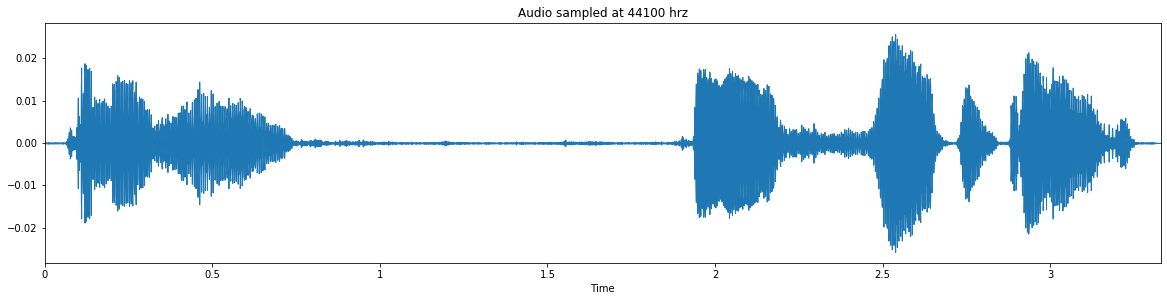

In [219]:
# Let's examin the waveplot of our sample file

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(y, sr=sr)
plt.title('Audio sampled at 44100 hrz')

### Audio listening bench

In [431]:
# We can plug in the different audio file names and play them
import IPython.display as ipd
ipd.Audio('data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented/2WGyTLYerpo_9.wav') # load a local WAV file

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<a id = "mfcc"></a>
## MFCC

Here we'll examine our MFCC data further.

The MFCCs are coefficients that display a change in Frequencies in the audio sample. They come in the form of a 2D array. After reading some research papers. It is widely acceptable to use the mean values per feature of the matrix.

Let's examine a single MFCC file below. This is the same audio file we extracted above

We chose librosa because of it's ease of use and because it's python based and well documented. If needed, realtime analysis can also be performed using librosa which further aided the decision

In [12]:
# Code to extract MFCC from image file
mf = librosa.feature.mfcc(y, sr=sr, n_mfcc = 13, hop_length = 160)

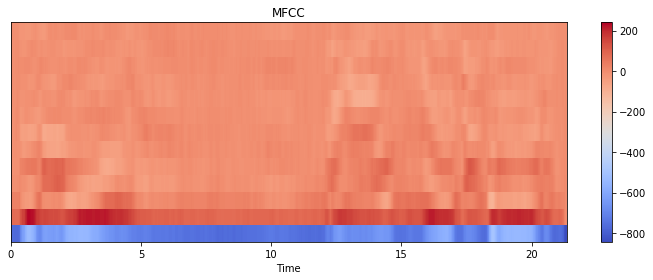

In [13]:
# Plot the coefficients
plt.figure(figsize=(10, 4))
>>> librosa.display.specshow(mf, x_axis='time')
>>> plt.colorbar()
>>> plt.title('MFCC')
>>> plt.tight_layout()
>>> plt.show()

We can see here that our highest coefficients were in the first row of the MFCC. 

In [14]:
audio = os.listdir('data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented')
audio = np.asarray(audio)

### Bench for testing different audio features. 

For this next bit of features extraction, we have played around with a few different features and have decided the ones that are most useful for us. 

n_mfcc ---->
hop_lenght ---->
sample rate -----> 

Notice that we cut off the duration at 2.5 seconds. This is slightly less than 4.2seconds which is the average lenght of our audio files. 

We've tried a number of different lenghts but the accuracy remained the same so we chose to go with a lower duration to reduce NaN values.

We do this because we want to avoid NAN values that will be created as the result of longer files having more features than the shorter ones. 


In [28]:
# sr=22500
# n_mfcc = 13 
# hop_lenght = 160
# We will use 3 different duration lenghts here: 2.5, 3.5 and 4.5. After doing some modelling it seems that 2.5s is the sweet
# spot as it reduces our features and doesn't affect accuracy alot

# Let's extract MFCC values and average them over all the audio files available in our dataset and save them to a list
mfcccs = []
path = 'data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented'
for filename in sorted(glob.glob(os.path.join(path, '*.wav'))):
    x, sr = librosa.load(filename,duration=2.5, sr = 22500)
    mfccs = np.mean(librosa.feature.mfcc(x, sr=sr,  n_mfcc = 13, hop_length = 160), axis= 0)
    mfcccs.append(mfccs)

In [816]:
# Sanity check to confirm if the audio files are being extracted in the same order as the sentiment and Text files.
for filename in sorted(glob.glob(os.path.join(path, '*.wav'))):
    print(filename)

data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_1.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_10.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_11.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_12.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_13.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_2.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_3.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_4.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_5.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_6.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_7.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_8.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\03bSnISJMiM_9.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\0h-zjBukYpk_1.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\0h-zjBukYpk_10.wav
data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented\0h-zjBukYpk_11.wav
da

In [29]:
# Convert the list to a data Frame

mfcc = pd.DataFrame(mfcccs)

In [37]:
# Sanity check
mfcc

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,-50.300379,-50.383061,-50.725314,-51.427882,-52.221268,-52.298492,-50.840084,-49.328397,-48.203806,-46.476463,...,-45.008132,-45.154607,-45.103449,-45.194614,-43.545242,-38.044742,-33.404765,-30.337301,-28.510144,-27.636472
1,-36.026983,-36.291206,-37.150645,-38.787734,-41.588613,-45.823580,-49.182992,-49.543512,-47.384266,-43.509514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-49.470204,-48.939091,-48.642957,-48.663554,-49.259678,-50.046580,-49.419755,-48.561246,-47.929745,-47.412296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-53.879242,-53.722571,-53.593352,-53.643235,-53.748149,-53.405391,-51.058711,-47.099215,-44.141157,-41.848321,...,-45.813412,-45.275974,-45.179930,-45.506079,-46.154899,-47.083504,-48.386144,-49.889543,-50.924124,-51.285039
4,-45.375561,-45.784450,-46.855798,-48.617616,-50.571527,-51.257761,-49.420225,-47.445893,-45.255716,-42.953839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,-31.326061,-31.522175,-32.158524,-33.261679,-34.773323,-36.445470,-37.207942,-37.268403,-37.716862,-38.420700,...,-29.923499,-30.212092,-30.630906,-31.018414,-30.895568,-28.783485,-26.977135,-25.827635,-25.167411,-24.895371
2195,-16.782538,-16.814602,-17.362150,-18.633373,-20.687419,-23.239659,-24.743586,-25.059898,-25.607429,-26.214991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2196,-30.193318,-30.354187,-30.872850,-31.806098,-33.143447,-34.731403,-35.723044,-36.295343,-36.434593,-36.561471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2197,-26.487752,-26.701739,-27.404977,-28.741033,-30.756685,-33.232259,-34.919240,-35.219830,-35.403958,-35.248858,...,-27.570163,-27.379355,-27.464716,-27.881504,-27.024329,-24.837222,-23.386887,-22.020281,-20.994751,-20.448961


In [38]:
# Get a sum of the Null values
mfcc.isna().sum().sum()


78282

In [39]:
# How many data points in the MFCC dataframe?
len(mfcc)

2199

In [48]:
# Fill in all the NaN values with zero
mfcc = mfcc.fillna(0)
mfcc

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,-50.300379,-50.383061,-50.725314,-51.427882,-52.221268,-52.298492,-50.840084,-49.328397,-48.203806,-46.476463,...,-45.008132,-45.154607,-45.103449,-45.194614,-43.545242,-38.044742,-33.404765,-30.337301,-28.510144,-27.636472
1,-36.026983,-36.291206,-37.150645,-38.787734,-41.588613,-45.823580,-49.182992,-49.543512,-47.384266,-43.509514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-49.470204,-48.939091,-48.642957,-48.663554,-49.259678,-50.046580,-49.419755,-48.561246,-47.929745,-47.412296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-53.879242,-53.722571,-53.593352,-53.643235,-53.748149,-53.405391,-51.058711,-47.099215,-44.141157,-41.848321,...,-45.813412,-45.275974,-45.179930,-45.506079,-46.154899,-47.083504,-48.386144,-49.889543,-50.924124,-51.285039
4,-45.375561,-45.784450,-46.855798,-48.617616,-50.571527,-51.257761,-49.420225,-47.445893,-45.255716,-42.953839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,-31.326061,-31.522175,-32.158524,-33.261679,-34.773323,-36.445470,-37.207942,-37.268403,-37.716862,-38.420700,...,-29.923499,-30.212092,-30.630906,-31.018414,-30.895568,-28.783485,-26.977135,-25.827635,-25.167411,-24.895371
2195,-16.782538,-16.814602,-17.362150,-18.633373,-20.687419,-23.239659,-24.743586,-25.059898,-25.607429,-26.214991,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2196,-30.193318,-30.354187,-30.872850,-31.806098,-33.143447,-34.731403,-35.723044,-36.295343,-36.434593,-36.561471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2197,-26.487752,-26.701739,-27.404977,-28.741033,-30.756685,-33.232259,-34.919240,-35.219830,-35.403958,-35.248858,...,-27.570163,-27.379355,-27.464716,-27.881504,-27.024329,-24.837222,-23.386887,-22.020281,-20.994751,-20.448961


checkinng the suize of the features extracted per audio file 

<a id = "spectrogram"></a>
## Sentiment Classification using Spectrogram images(Bonus)

As you will see below in the models we run on the MFCC data. Our models perform very poorly. This could be because the movie reviewers did not portray sentiment by the tone and inflections in their voice but rather focused more on what was being said. 

However, we would like to try a unique approach of extracting the spectrograms of the audio files, extracting  and running a 2D CNN on it. We hope that by converting this to a computer vision problem, we will be able to get better results for our model.

First Off, what is a Spectrogram? A Spectrogram is the representation of a spectrum of frequencies of an audio signal. The Brightness of the colors determine the loudness, the unit for which is decibels. The X-axis denotes time vs the Y-Axis which denotes frequency. 

In this experiment we hoped that our model would be able to "learn" to distinguish between the images of a spectrogram that represent a postive and negative sentiment.

Let's look at the parameters that we can tweak extracting the spectrogram:

- fmax: frequency range. half of the sampling rate
- n_mel: this is the number of bins the mel scale has been set to. The mel scale is a method of scaling that is applied to scale the frequency values to match human perception levels. We do this because humans are better at perceiving differences frequencies at lower values(500-1000) but not so good at higher values(10000 - 10500)
- sampling rate: same as MFCC

In [18]:
# Let's load in just one file to run some just take a peak at our data
x, sr = librosa.load('data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented/03bSnISJMiM_8.wav',sr=45000)

In [19]:
# Let's get the spectrogram feature
S = librosa.feature.melspectrogram(x, sr=sr, n_mels=128,fmax=8000)

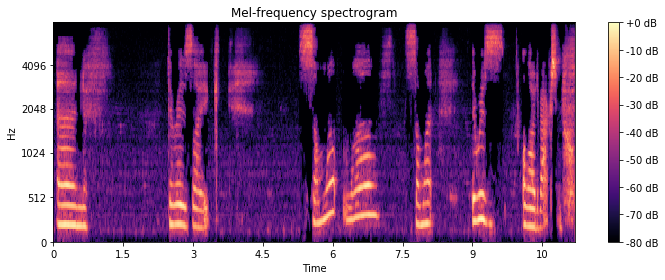

In [23]:
# Let's plot our spectrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.savefig('.png', dpi=300)
plt.show()


dB(decibels) is the measure of loudness. We can see that the spectrogram shows us the frequency and loudness over time. 

Next we extract the spectrogram for all the files. 

In [ ]:
# Now let's extract the features for each file and label it with its sentiment. We must make sure to sort it the same way the
# other files have been sorted. Hence we use the sorted function. 
# We chose not to show the results becuase the file size becomes too big.
path = 'data/CMU_MOSI/Raw/Audio/WAV_16000/Segmented'
counter = 0
for filename in sorted(glob.glob(os.path.join(path, '*.wav'))):
    x, sr = librosa.load(filename,sr=22500)
    S = librosa.feature.melspectrogram(x, sr=sr, n_mels=128,
                                        fmax=8000)
    plt.figure(figsize=(10, 4))
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, 
                             #x_axis='time',
                             #y_axis='mel',
                             sr=sr,
                              fmax=8000)
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    # Saving figure by label and ascending order in index
    plt.savefig(str(y[counter]) + '----' + str(counter) + '.png', dpi=300, bbox_inches='tight')
    counter += 1
    plt.show()
    
    # After labelling the files with their sentiments. We sorted them by classes into different folders. 
    # Which we will use in our next section

We've saved our data to png files. Now let's bring it back into python so we can do some cleaning and transforming.

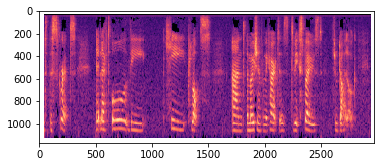

In [17]:
plt.imshow(X_train_img[1800])
plt.show()

In [2]:
# import our required packages
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
height = 250 # specify the shape we want the images to be preprocessed to 
width = 250
channels = 3

# Get Images from Directories
train_datagen = ImageDataGenerator(
                                 rescale=1./255, 
#                                 rotation_range = 30,
#                                 shear_range=0.2,
#                                 zoom_range=0.2
#                                 ,horizontal_flip=True
                                  )

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory('data/new_spectrogram_binary/train',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 )

valid_generator=valid_datagen.flow_from_directory('data/new_spectrogram_binary/validation',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 1761 images belonging to 2 classes.
Found 438 images belonging to 2 classes.


In [169]:
# Code for running 5 class classification. This code is just to show that we ran this experiment but we do not show the results.
# only the binary classification results are shown
height = 250 # specify the shape we want the images to be preprocessed to 
width = 250
channels = 3

# Get Images from Directories (Only Augment Training Images)
train_datagen = ImageDataGenerator(
                                 rescale=1./255, 
#                                 rotation_range = 30,
#                                 shear_range=0.2,
#                                 zoom_range=0.2
#                                 ,horizontal_flip=True
                                  )

# valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory('data/new spec',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=2199,
                                                 )

# valid_generator=valid_datagen.flow_from_directory('images/validation',
#                                                  target_size=(height,width),
#                                                  color_mode='rgb',
#                                                  batch_size=32,
#                                                  class_mode='categorical')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/new spec'

In [147]:
X1[31].shape

(224, 224, 3)

In [5]:
train_generator

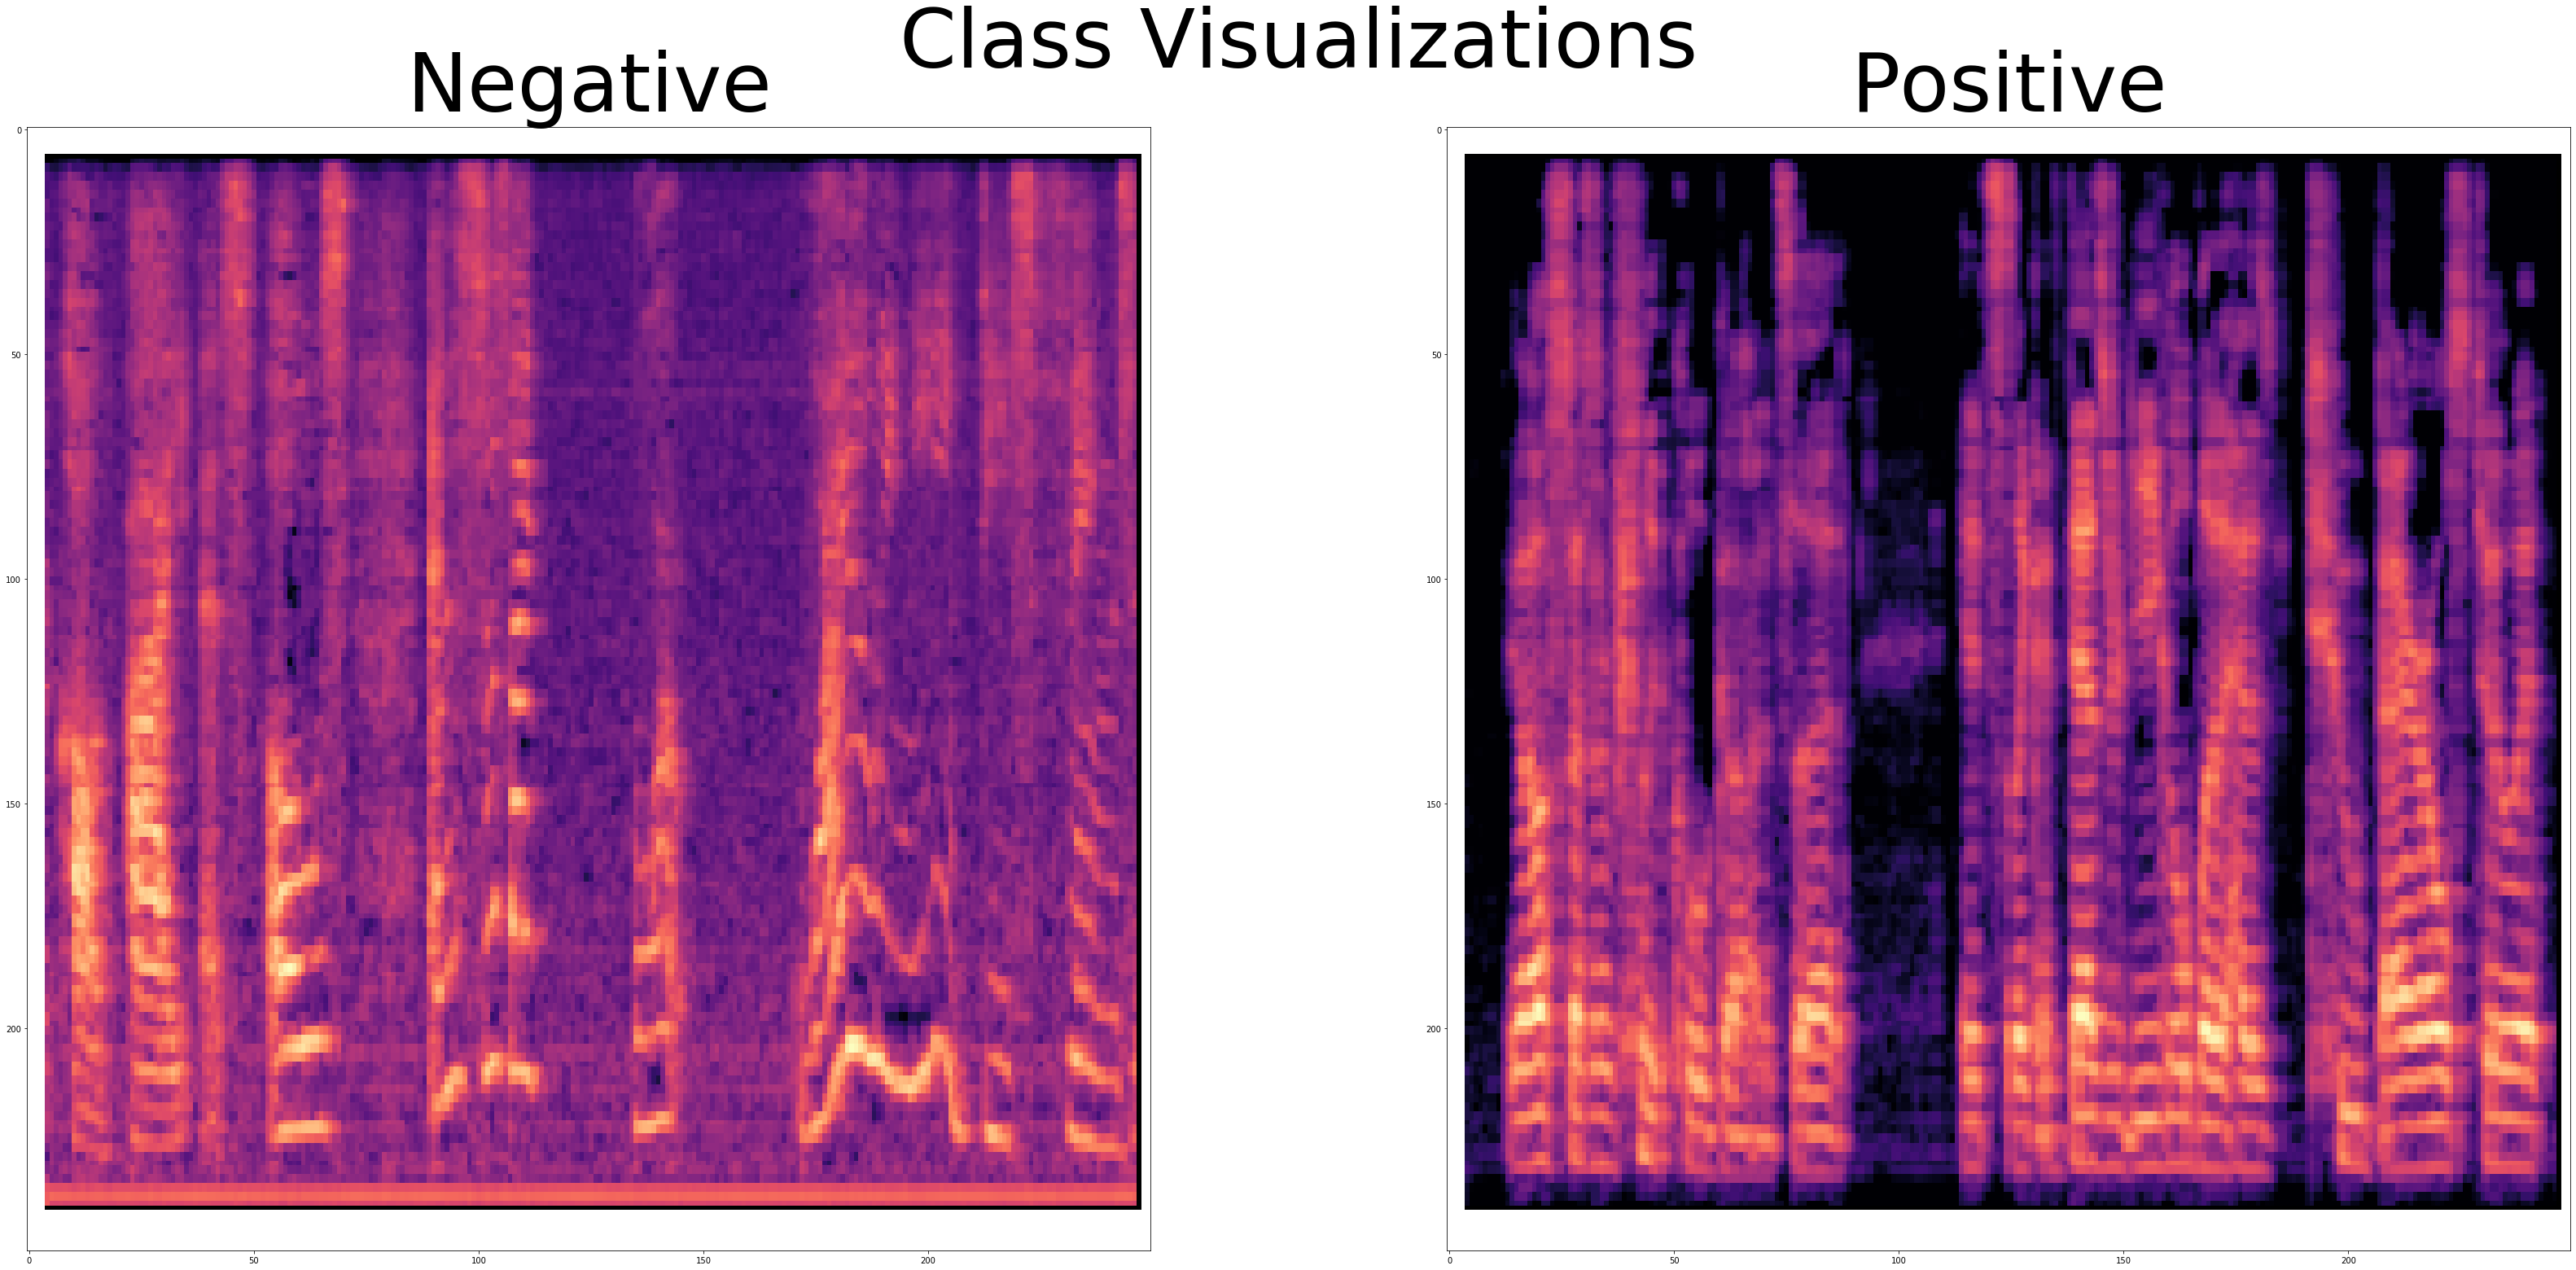

In [6]:
# Binary Classification
X2,y2 = train_generator.next() # iterating over our batch to get x (image matrices) and y (labels)

labels = np.argmax(y2,axis=1) # getting all the class labels

class_names = [ 'Negative',
                'Positive',
                ]

class_names = [i.title().replace('_',' ') for i in class_names]

f,axes = plt.subplots(1,2,figsize = (50,21))
axes = np.ravel(axes) # flatten

for i in range(2):
    index = np.argmax(labels==i) 
    axes[i].imshow(X2[index])
    axes[i].set_title(class_names[i],size = 100,y=1.01)
plt.suptitle('Class Visualizations',size = 100,y=1.03)
plt.tight_layout()

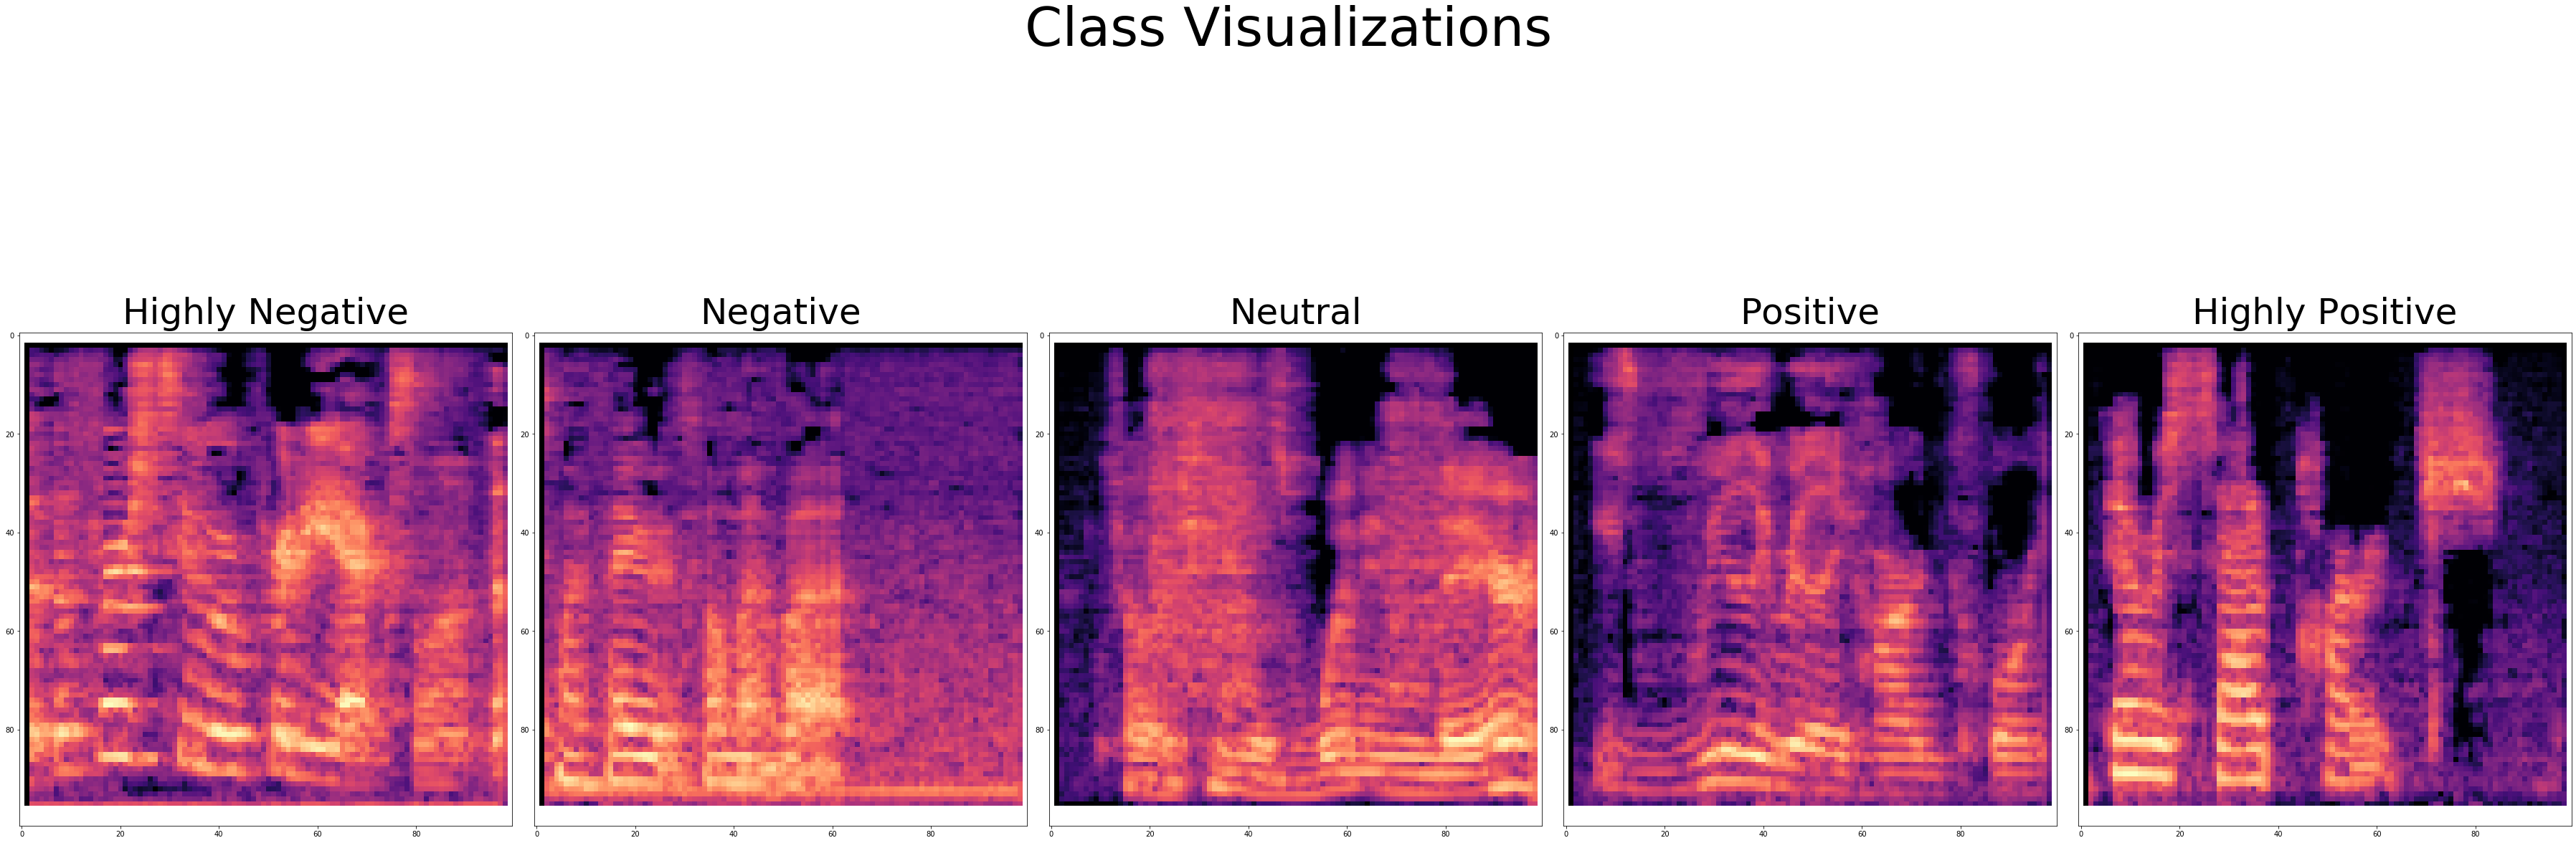

In [177]:
# Code for running 5 class classification. This code is just to show that we ran this experiment but we do not show the results.
# only the binary classification results are shown

# 5 Class classification
X1,y1 = train_generator.next() # iterating over our batch to get x (image matrices) and y (labels)

labels = np.argmax(y1,axis=1) # getting all the class labels

class_names = ['Highly Negative',
                'Negative',
                'Neutral',
                'Positive',
                'Highly Positive'
                ]

class_names = [i.title().replace('_',' ') for i in class_names]

f,axes = plt.subplots(1,5,figsize = (50,21))
axes = np.ravel(axes) # flatten

for i in range(5):
    index = np.argmax(labels==i) 
    axes[i].imshow(X1[index])
    axes[i].set_title(class_names[i],size = 50,y=1.01)
plt.suptitle('Class Visualizations',size = 75,y=1.03)
plt.tight_layout()

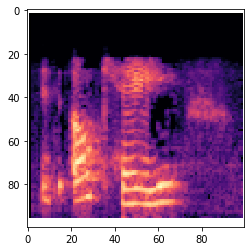

In [171]:
plt.imshow(X1[1000])

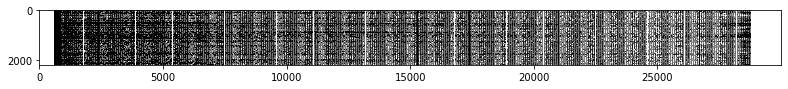

Our flat image shape is: (2199, 30000)


In [172]:
# I wanted to see what it looks like if we flatten the data. 
flat_image = X2.reshape(X2.shape[0], X2.shape[1] * X2.shape[2] * X2.shape[3])

plt.figure(figsize=(50,1))
plt.imshow(flat_image, cmap='gray')
plt.show()

print(f'Our flat image shape is: {flat_image.shape}')

# Too many features. We cannot use the flattenned dataset to our advantage

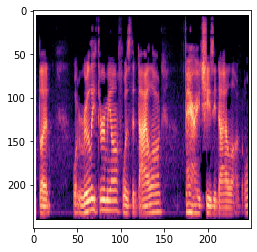

In [175]:
plt.imshow(X_rem1[1000])

In [7]:
# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model = Sequential()

CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (250, 250, 3)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2))) # pooling to reduce computation time

CNN_model.add(Dropout(0.25)) # turn of 25% of the nodes to prevent overfitting/ learning more promiment features
CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='relu'))# Using Relu because of its faster learning rate
CNN_model.add(Dropout(0.5))  # turn of 50% of the nodes to prevent overfitting
CNN_model.add(Dense(2, activation='softmax')) # because this is a classification problem, We use softmax gives outputs that add up to 1

CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 246, 246, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 123, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 123, 123, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 968256)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               123936896 
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [9]:
# Compile the model with the desired loss function, optimizer, and metric to optimize
CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [16]:

# THIS WILL TAKE A LONG TIME TO RUN!!!

#Assign Callback. Want to be able to stop 
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.0001, 
                           patience=5, 
                           mode='min', 
                           verbose=1)

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation on the test data after each batch

CNN_model.fit_generator(generator = train_generator,          
              epochs = 30,
              verbose = 1,
              validation_data = valid_generator,
              callbacks=[early_stop])

Epoch 1/30
56/56 [==============================] - 152s 3s/step - loss: 2.5383 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.5342
Epoch 2/30
56/56 [==============================] - 148s 3s/step - loss: 0.6877 - accuracy: 0.5480 - val_loss: 0.7008 - val_accuracy: 0.5342
Epoch 3/30
56/56 [==============================] - 149s 3s/step - loss: 0.6830 - accuracy: 0.5826 - val_loss: 0.6967 - val_accuracy: 0.5388
Epoch 4/30
56/56 [==============================] - 151s 3s/step - loss: 0.6678 - accuracy: 0.6002 - val_loss: 0.7119 - val_accuracy: 0.5571
Epoch 5/30
56/56 [==============================] - 157s 3s/step - loss: 0.5966 - accuracy: 0.6797 - val_loss: 0.7761 - val_accuracy: 0.4566
Epoch 6/30
56/56 [==============================] - 160s 3s/step - loss: 0.4473 - accuracy: 0.7967 - val_loss: 0.8821 - val_accuracy: 0.4863
Epoch 00006: early stopping


Let's end our experiment here. Our Binary classification on the images is performing really poorly. We will move on to our next task.

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

<a id="text"></a>
# Text Data

## #EDA and Cleaning

In [1]:
# First we check in which order python extracts the files
import os             
all_files = os.listdir("data/CMU_MOSI/Raw/Transcript/Segmented/")   # imagine you're one directory above test dir
all_files


['03bSnISJMiM.annotprocessed',
 '0h-zjBukYpk.annotprocessed',
 '1DmNV9C1hbY.annotprocessed',
 '1iG0909rllw.annotprocessed',
 '2iD-tVS8NPw.annotprocessed',
 '2WGyTLYerpo.annotprocessed',
 '5W7Z1C_fDaE.annotprocessed',
 '6Egk_28TtTM.annotprocessed',
 '6_0THN4chvY.annotprocessed',
 '73jzhE8R1TQ.annotprocessed',
 '7JsX8y1ysxY.annotprocessed',
 '8d-gEyoeBzc.annotprocessed',
 '8OtFthrtaJM.annotprocessed',
 '8qrpnFRGt2A.annotprocessed',
 '9c67fiY0wGQ.annotprocessed',
 '9J25DZhivz8.annotprocessed',
 '9qR7uwkblbs.annotprocessed',
 '9T9Hf74oK10.annotprocessed',
 'Af8D0E4ZXaw.annotprocessed',
 'aiEXnCPZubE.annotprocessed',
 'atnd_PF-Lbs.annotprocessed',
 'Bfr499ggo-0.annotprocessed',
 'BI97DNYfe5I.annotprocessed',
 'BioHAh1qJAQ.annotprocessed',
 'bOL9jKpeJRs.annotprocessed',
 'bvLlb-M3UXU.annotprocessed',
 'BvYR0L6f2Ig.annotprocessed',
 'BXuRRbG0Ugk.annotprocessed',
 'c5xsKMxpXnc.annotprocessed',
 'c7UH_rxdZv4.annotprocessed',
 'Ci-AH39fi3Y.annotprocessed',
 'Clx4VXItLTE.annotprocessed',
 'cM3Yna

hmmm. The order is actually not what we want it to be. The first thing we have to do is sort the text data frame in the same order as the Audio and sentiment file: "name of file"+"instance"(e.g. 5W7Z1C_fDaE_1). Let's do this now.

In [3]:
# First let's take a peek inside the a file of text
file1 = open("data/CMU_MOSI/Raw/Transcript/Segmented/_dI--eQ6qVU.annotprocessed", "r") 

In [4]:
file1.read()

'1_DELIM_ BUT I CAN SAFELY ASSURE YOU THAT EVEN IF THEY DIDNT IT WOULD STILL BE A HIT\n2_DELIM_AND I LOVED IT\n3_DELIM_I DONT KNOW IF FANS OF THE COMIC WOULD BE AS INCLINED TO SAY THE SAME BECAUSE I DONT KNOW HOW MUCH IT DIFFERS FROM THE COMIC OR RADIO PROGRAM THAT PEOPLE LIKE SO MUCH \n4_DELIM_BUT JUST GOING INTO THIS A AS AN OBSERVER AND SOMEONE WHO HAS NO IDEA IT WAS A FANTASTIC FILM IT WAS SO MUCH FUN\n5_DELIM_AND I WOULD TELL YOU RIGHT NOW IT WAS HILARIOUS\n6_DELIM_ IT WAS REALLY REALLY FUNNY\n7_DELIM_AND MOST OF YOU KNOW HES A PRETTY FUNNY GUY \n8_DELIM_ AND HE FUNNIED UP THIS MOVIE BIG TIME TOTALLY\n9_DELIM_ SO THAT DOESNT SURPRISE ME \n10_DELIM_ AND THE HUMOR IT WAS KIND OF NECESSARY\n11_DELIM_I FEEL LIKE IF THEY WOUDLNT HAVE INSERTED THE HUMOR INTO THIS MOVIE IT WOULDVE BEEN JUST TOO SERIOUS AND KIND OF BORING IN A SENSE \n12_DELIM_ BUT THE HUMOR REALLY JUST NAILED IT\n13_DELIM_AND THE ACTION SEQUENCES IN THIS MOVIE ARE TENSED\n14_DELIM_I LOVE WHEN PEOPLE DO THIS\n15_DELIM_ WH

Wow, this is one whole movie review, we don't want this, we actually want this file and all others like this broken down by instance so we can sort them.

Looks like the file is broken down into instances and broken down by delimeter and instance(e.g. 1_DELIM_). We can break this text file down into its instances by row by using a for loop. We faced the challenge of turning the filenames into the "name of file"+"instance" format described above. This turned out to be a fairly challenging exercise because of how the file names were annotated. We had to go through the following steps to convert the files.

- Use a for loop to break each movie review into its instances and append the name of the file on the end of it with a "$" in     between

In [6]:
text1 = []
counter = 0
path = 'data/CMU_MOSI/Raw/Transcript/Segmented/'
for filename in glob.glob(os.path.join(path, '*.annotprocessed')):
    tex = open(filename, "r")
    for x in tex: 
        text1.append(x)
        text1[counter] = filename+ '$' + x
        counter += 1

In [7]:
text1 = pd.DataFrame(text1)
text1

,0
0,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...
1,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...
2,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...
3,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...
4,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...
...,...
2194,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...
2195,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...
2196,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...
2197,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...


- Split each row in the dataframe by the "$" symbol.

In [8]:
text1['1'], text1['2'] = text1[0].str.split("$",1).str

- Split column 1 by the "." symbol

In [9]:
text1['3'], text1['4'] = text1['1'].str.split(".").str

- Split column 2 by the "_" to seperate the instance and the "DELIM" word from the text that we need

In [10]:
text1['5'], text1['6'], text1['7'] = text1['2'].str.split("_",2).str

- Let's combine the 2 columns that represent files and instance of the files. 

In [11]:
text1['1'] = text1['3'] + '_' + text1['5']

In [12]:
# perform Sanity checks here
text1

,0,1,2,3,4,5,6,7
0,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,1_DELIM_ANYHOW IT WAS REALLY GOOD \n,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,annotprocessed,1,DELIM,ANYHOW IT WAS REALLY GOOD \n
1,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,2_DELIM_THAY DID THEY DIDNT REALLY DO A WHOLE ...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,annotprocessed,2,DELIM,THAY DID THEY DIDNT REALLY DO A WHOLE BUNCH OF...
2,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,3_DELIM_ I MEAN THEY DID A LITTLE BIT OF IT \n,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,annotprocessed,3,DELIM,I MEAN THEY DID A LITTLE BIT OF IT \n
3,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,4_DELIM_ BUT NOT A WHOLE BUNCH \n,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,annotprocessed,4,DELIM,BUT NOT A WHOLE BUNCH \n
4,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,5_DELIM_AND THEY SHOULDVE I GUESS \n,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,annotprocessed,5,DELIM,AND THEY SHOULDVE I GUESS \n
...,...,...,...,...,...,...,...,...
2194,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,24_DELIM_ BUT THEY TOOK A NEW SPIN ON IT\n,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,annotprocessed,24,DELIM,BUT THEY TOOK A NEW SPIN ON IT\n
2195,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,25_DELIM_AND I JUST LOVED IT\n,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,annotprocessed,25,DELIM,AND I JUST LOVED IT\n
2196,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,26_DELIM_ AND I FEEL LIKE EVEN THOUGH THE FIGH...,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,annotprocessed,26,DELIM,AND I FEEL LIKE EVEN THOUGH THE FIGHTING SEQU...
2197,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,27_DELIM_SO I MEANT IF I WAS WEARING 3D GLASSE...,data/CMU_MOSI/Raw/Transcript/Segmented\_dI--eQ...,annotprocessed,27,DELIM,SO I MEANT IF I WAS WEARING 3D GLASSES AND WAS...


This gives us a new column that contains the name of the file in the order that we want it for sorting. 

- Now let's drop a few unnecessary columns.

In [13]:
# Let's drop a few columns that aren't necessary
text1.drop(columns = ['2','4','6'], inplace=True)

In [14]:
# Now we can sort the files by column '1'. We can see this column has the name and instance of the 
# file in the format that we want but just with the precurser of the file path. So we can now go ahead and sort them
text2 = text1.sort_values('1')
text2

,0,1,3,5,7
0,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,1,ANYHOW IT WAS REALLY GOOD \n
9,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,10,THERE IS SAD PART\n
10,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,11,A LOT OF SAD PARTS \n
11,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,12,BUT IT WAS REALLY REALLY AWESOME\n
12,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,data/CMU_MOSI/Raw/Transcript/Segmented\03bSnIS...,13,AND ITS A REALLY FUNNY \n
...,...,...,...,...,...
2106,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,5,BUT I JUST WASNT I JUST I DONT KNOW I DIDNT RE...
2107,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,6,I MEAN I HAD SOME SOME GOOD MOMENTS \n
2108,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,7,AND A FEW FUNNY PARTS\n
2109,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,data/CMU_MOSI/Raw/Transcript/Segmented\zhpQhgh...,8,BUT ALL IN ALL I JUST THOUGHT IT WAS REALLY OV...


In [15]:
# Now we can drop a few more columns 
text2.drop(columns = [0,'3','5'], inplace=True)

In [16]:
# And Finally perform the last cleaning steps
text2['1'] = text2['7'].str.strip("\n")
text2.drop(columns = ['7'], inplace=True)

# Rename the column
text2.rename(columns={'1': 'review'}, inplace=True)

In [17]:
# Final Sanity check. Looks good now. We've saved this dataframe and it can be used for our modeling going forward.

text2

,review
0,ANYHOW IT WAS REALLY GOOD
9,THERE IS SAD PART
10,A LOT OF SAD PARTS
11,BUT IT WAS REALLY REALLY AWESOME
12,AND ITS A REALLY FUNNY
...,...
2106,BUT I JUST WASNT I JUST I DONT KNOW I DIDNT RE...
2107,I MEAN I HAD SOME SOME GOOD MOMENTS
2108,AND A FEW FUNNY PARTS
2109,BUT ALL IN ALL I JUST THOUGHT IT WAS REALLY OV...


For now we'll take a peak at the sentiment data.

<a id = "senti"></a>
# Sentiment 

Now let's load our file with the Sentiment labels

In [37]:
sentiment = pd.read_csv('data/OpinionLevelSentiment.csv')

In [38]:
# Check the DataFrame
sentiment

,start_time,end_time,audio_file_name,instance_of_file,sentiment
0,27.879138,32.927664,_dI--eQ6qVU,1,2.4
1,45.548980,47.783900,_dI--eQ6qVU,2,3.0
2,47.783900,59.247846,_dI--eQ6qVU,3,-0.2
3,59.247846,68.277324,_dI--eQ6qVU,4,3.0
4,68.277324,71.200680,_dI--eQ6qVU,5,3.0
...,...,...,...,...,...
2194,147.217914,153.703175,ZUXBRvtny7o,30,0.4
2195,157.265079,161.256009,ZUXBRvtny7o,31,1.4
2196,161.256009,173.049206,ZUXBRvtny7o,32,0.4
2197,173.049206,175.224263,ZUXBRvtny7o,33,0.8


In [39]:
# Are there any null values
sentiment.isna().sum().sum()

0

No Null values. This is good! Though we do notice that the order of the files is inconsistent with the way the audio files have been imported. 

If we go back up to the way the audio files have been imported we see that the file names are named like this _dI--eQ6qVU_2. This makes sense, if we can combine audio_file_name and instance_of_file and then sort it used the sorted() method, we will be able to get the sentiment labels in the same order as the audio files.

In [40]:
# Let's now combine the 2 file names and add it in as a separate column and see the results
sentiment['file_name_plus_instance'] = sentiment['audio_file_name'] + '_' + sentiment['instance_of_file'].astype(str)
sentiment

,start_time,end_time,audio_file_name,instance_of_file,sentiment,file_name_plus_instance
0,27.879138,32.927664,_dI--eQ6qVU,1,2.4,_dI--eQ6qVU_1
1,45.548980,47.783900,_dI--eQ6qVU,2,3.0,_dI--eQ6qVU_2
2,47.783900,59.247846,_dI--eQ6qVU,3,-0.2,_dI--eQ6qVU_3
3,59.247846,68.277324,_dI--eQ6qVU,4,3.0,_dI--eQ6qVU_4
4,68.277324,71.200680,_dI--eQ6qVU,5,3.0,_dI--eQ6qVU_5
...,...,...,...,...,...,...
2194,147.217914,153.703175,ZUXBRvtny7o,30,0.4,ZUXBRvtny7o_30
2195,157.265079,161.256009,ZUXBRvtny7o,31,1.4,ZUXBRvtny7o_31
2196,161.256009,173.049206,ZUXBRvtny7o,32,0.4,ZUXBRvtny7o_32
2197,173.049206,175.224263,ZUXBRvtny7o,33,0.8,ZUXBRvtny7o_33


In [41]:
# Now we can sort by the last column and see what we achieve.
sentiment = sentiment.sort_values('file_name_plus_instance')
sentiment

,start_time,end_time,audio_file_name,instance_of_file,sentiment,file_name_plus_instance
190,52.732653,56.045125,03bSnISJMiM,1,2.4,03bSnISJMiM_1
199,93.549887,95.056463,03bSnISJMiM,10,-1.2,03bSnISJMiM_10
200,95.056463,97.201587,03bSnISJMiM,11,-0.5,03bSnISJMiM_11
201,97.201587,99.895465,03bSnISJMiM,12,2.2,03bSnISJMiM_12
202,168.838775,170.485034,03bSnISJMiM,13,1.8,03bSnISJMiM_13
...,...,...,...,...,...,...
2134,32.348980,35.801134,zhpQhgha_KU,5,-2.2,zhpQhgha_KU_5
2135,35.801134,37.726757,zhpQhgha_KU,6,1.0,zhpQhgha_KU_6
2136,37.726757,38.993878,zhpQhgha_KU,7,1.0,zhpQhgha_KU_7
2137,38.993878,44.192063,zhpQhgha_KU,8,-1.0,zhpQhgha_KU_8


Looks like our files have dataframe rows have been sorted in the way we wanted. We can now go ahead and combine the audio data with the sentiment labels

In [42]:
# Drop all columns apart from sentiment 
sentiment.drop(['audio_file_name', 'instance_of_file', 'start_time', 'end_time ', 'file_name_plus_instance'], axis=1, inplace = True)

In [43]:
# Sanity Check
sentiment

,sentiment
190,2.4
199,-1.2
200,-0.5
201,2.2
202,1.8
...,...
2134,-2.2
2135,1.0
2136,1.0
2137,-1.0


In [44]:
#reset indexes immediately
sentiment = sentiment.reset_index()

In [49]:
# Now let's concatinate the 2 files and save it 
a_df = pd.concat([mfcc, sentiment], axis=1)

In [50]:
# Drop the extra index
a_df.drop(['index'], axis=1, inplace = True)

In [51]:
# Sanity Check
a_df

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,349,350,351,sentiment
0,-50.300379,-50.383061,-50.725314,-51.427882,-52.221268,-52.298492,-50.840084,-49.328397,-48.203806,-46.476463,...,-45.154607,-45.103449,-45.194614,-43.545242,-38.044742,-33.404765,-30.337301,-28.510144,-27.636472,2.4
1,-36.026983,-36.291206,-37.150645,-38.787734,-41.588613,-45.823580,-49.182992,-49.543512,-47.384266,-43.509514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.2
2,-49.470204,-48.939091,-48.642957,-48.663554,-49.259678,-50.046580,-49.419755,-48.561246,-47.929745,-47.412296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.5
3,-53.879242,-53.722571,-53.593352,-53.643235,-53.748149,-53.405391,-51.058711,-47.099215,-44.141157,-41.848321,...,-45.275974,-45.179930,-45.506079,-46.154899,-47.083504,-48.386144,-49.889543,-50.924124,-51.285039,2.2
4,-45.375561,-45.784450,-46.855798,-48.617616,-50.571527,-51.257761,-49.420225,-47.445893,-45.255716,-42.953839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,-31.326061,-31.522175,-32.158524,-33.261679,-34.773323,-36.445470,-37.207942,-37.268403,-37.716862,-38.420700,...,-30.212092,-30.630906,-31.018414,-30.895568,-28.783485,-26.977135,-25.827635,-25.167411,-24.895371,-2.2
2195,-16.782538,-16.814602,-17.362150,-18.633373,-20.687419,-23.239659,-24.743586,-25.059898,-25.607429,-26.214991,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2196,-30.193318,-30.354187,-30.872850,-31.806098,-33.143447,-34.731403,-35.723044,-36.295343,-36.434593,-36.561471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2197,-26.487752,-26.701739,-27.404977,-28.741033,-30.756685,-33.232259,-34.919240,-35.219830,-35.403958,-35.248858,...,-27.379355,-27.464716,-27.881504,-27.024329,-24.837222,-23.386887,-22.020281,-20.994751,-20.448961,-1.0


In [58]:
# We want to run a few tests and EDA on this dataframe. so we'll save it to a different variable
a_df2 = a_df

In [54]:
# All our values seem to be floats. This is fine for now. We will deal with the last column(sentiment) in a bit
a_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Columns: 353 entries, 0 to sentiment
dtypes: float64(353)
memory usage: 5.9 MB


In [401]:
# How many values in the value counts
a_df2['sentiment'].value_counts()

 2.0    463
-1.0    404
-0.0    403
-2.0    385
 1.0    379
 3.0    85 
-3.0    80 
Name: sentiment, dtype: int64

<a id = "sentilabels"></a>
### Grouping and ungrouping sentiment classes

Let's take a look at the representation of our classes.

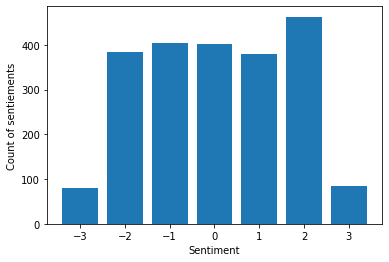

In [25]:
# Let's plot the probability distribution
values, counts = np.unique(a_df2['sentiment'], return_counts=True)
plt.figure()
plt.bar(values, counts)
plt.xlabel('Sentiment')
plt.ylabel('Count of sentiements')
plta.show()

# This is interesting

-3 and +3 classes are majorly underrepresented. This means that our model will not be aptly trained for these 2 classes. At this point we could either choose to remove these classes or mix them in with +2 and -2. 

First Let's try removing +3 and -3

In [39]:
a_df2 = a_df2[a_df2.sentiment != 3]

In [41]:
a_df2 = a_df2[a_df2.sentiment != -3]

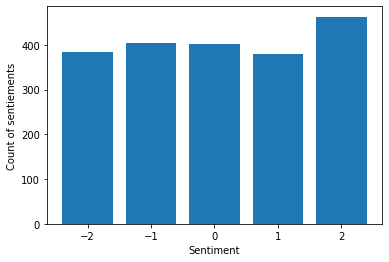

In [72]:
# Let's plot the probability distribution
values, counts = np.unique(a_df2['sentiment'], return_counts=True)
plt.figure()
plt.bar(values, counts)
plt.xlabel('Sentiment')
plt.ylabel('Count of sentiements')
plt.show()

We ran a few tests and this does not help improve model accuracy at all. Next we will try to combine -3 class and -2 class as well as +3 and +2 class.

In [61]:
a_df2 = a_df2.replace({-3: 0, -2: 0, -1:1, 0:2, 1:3, 2:4, 3:4})

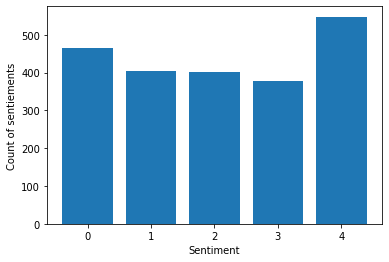

In [62]:
values, counts = np.unique(a_df2['sentiment'], return_counts=True)
plt.figure()
plt.bar(values, counts)
plt.xlabel('Sentiment')
plt.ylabel('Count of sentiements')
plt.show()

This helps our models improve accuracy. We will be using this distribution for our 5 class classification.

Let's see what our class distribution will look like if turn it into a binary classification problem. 

Values >=0 are positive and rest are negative. We realize that this may skew the classification towards the positive class but our assumption is that it won't affect our model badly if it is only a slight imbalance.

In [59]:
# Convert the continous sentiment value to binary
a_df2['sentiment'] = np.where(a_df2['sentiment'] >= 0, 1,0)

In [60]:
# Sanity check, it worked!
a_df2

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,349,350,351,sentiment
0,-50.300379,-50.383061,-50.725314,-51.427882,-52.221268,-52.298492,-50.840084,-49.328397,-48.203806,-46.476463,...,-45.154607,-45.103449,-45.194614,-43.545242,-38.044742,-33.404765,-30.337301,-28.510144,-27.636472,1
1,-36.026983,-36.291206,-37.150645,-38.787734,-41.588613,-45.823580,-49.182992,-49.543512,-47.384266,-43.509514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,-49.470204,-48.939091,-48.642957,-48.663554,-49.259678,-50.046580,-49.419755,-48.561246,-47.929745,-47.412296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,-53.879242,-53.722571,-53.593352,-53.643235,-53.748149,-53.405391,-51.058711,-47.099215,-44.141157,-41.848321,...,-45.275974,-45.179930,-45.506079,-46.154899,-47.083504,-48.386144,-49.889543,-50.924124,-51.285039,1
4,-45.375561,-45.784450,-46.855798,-48.617616,-50.571527,-51.257761,-49.420225,-47.445893,-45.255716,-42.953839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,-31.326061,-31.522175,-32.158524,-33.261679,-34.773323,-36.445470,-37.207942,-37.268403,-37.716862,-38.420700,...,-30.212092,-30.630906,-31.018414,-30.895568,-28.783485,-26.977135,-25.827635,-25.167411,-24.895371,0
2195,-16.782538,-16.814602,-17.362150,-18.633373,-20.687419,-23.239659,-24.743586,-25.059898,-25.607429,-26.214991,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2196,-30.193318,-30.354187,-30.872850,-31.806098,-33.143447,-34.731403,-35.723044,-36.295343,-36.434593,-36.561471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2197,-26.487752,-26.701739,-27.404977,-28.741033,-30.756685,-33.232259,-34.919240,-35.219830,-35.403958,-35.248858,...,-27.379355,-27.464716,-27.881504,-27.024329,-24.837222,-23.386887,-22.020281,-20.994751,-20.448961,0


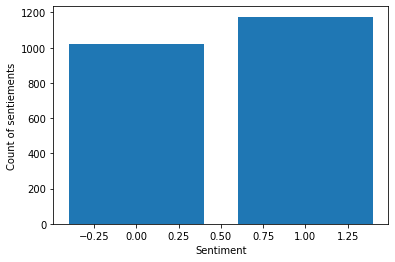

In [61]:
values, counts = np.unique(a_df2['sentiment'], return_counts=True)
plt.figure()
plt.bar(values, counts)
plt.xlabel('Sentiment')
plt.ylabel('Count of sentiements')
plt.show()

The binary classes are fairly similar. No data augmentation is required

Let's end our exploration of the sentiment values here. 

In [389]:
# Let's prepare our dataset for audio modelling and break the a_df dataframe to independent and dependent variables
X = a_df.drop(columns = ['sentiment'])
y = a_df['sentiment']

##### Converting to 5 class(use this code)

In [232]:
# 5 CLASS
y = y.replace({-2: 0, -1: 1, 0:2, 1:3, 2:4})

In [390]:
X

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,-50.300379,-50.383061,-50.725314,-51.427882,-52.221268,-52.298492,-50.840084,-49.328397,-48.203806,-46.476463,...,-45.008132,-45.154607,-45.103449,-45.194614,-43.545242,-38.044742,-33.404765,-30.337301,-28.510144,-27.636472
1,-36.026983,-36.291206,-37.150645,-38.787734,-41.588613,-45.823580,-49.182992,-49.543512,-47.384266,-43.509514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-49.470204,-48.939091,-48.642957,-48.663554,-49.259678,-50.046580,-49.419755,-48.561246,-47.929745,-47.412296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-53.879242,-53.722571,-53.593352,-53.643235,-53.748149,-53.405391,-51.058711,-47.099215,-44.141157,-41.848321,...,-45.813412,-45.275974,-45.179930,-45.506079,-46.154899,-47.083504,-48.386144,-49.889543,-50.924124,-51.285039
4,-45.375561,-45.784450,-46.855798,-48.617616,-50.571527,-51.257761,-49.420225,-47.445893,-45.255716,-42.953839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,-31.326061,-31.522175,-32.158524,-33.261679,-34.773323,-36.445470,-37.207942,-37.268403,-37.716862,-38.420700,...,-29.923499,-30.212092,-30.630906,-31.018414,-30.895568,-28.783485,-26.977135,-25.827635,-25.167411,-24.895371
2195,-16.782538,-16.814602,-17.362150,-18.633373,-20.687419,-23.239659,-24.743586,-25.059898,-25.607429,-26.214991,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2196,-30.193318,-30.354187,-30.872850,-31.806098,-33.143447,-34.731403,-35.723044,-36.295343,-36.434593,-36.561471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2197,-26.487752,-26.701739,-27.404977,-28.741033,-30.756685,-33.232259,-34.919240,-35.219830,-35.403958,-35.248858,...,-27.570163,-27.379355,-27.464716,-27.881504,-27.024329,-24.837222,-23.386887,-22.020281,-20.994751,-20.448961


##### Converting to binary(use this code)

In [391]:
#
y= np.where(y >= 0, 1,0)

In [392]:
y

array([1, 0, 0, ..., 1, 0, 0])

<a id="model"></a>
# Modeling

<a id="audiomodel"></a>
## Audio Data Modeling
####  Basic Modelling - No PCA 

We wanted to run a few models to get a base line idea of our how the model perform with just MFCC Data. No Hyper Parameter Optimization is performed here. 

In [421]:
# Train test Split. Stratify y to maintain the distribution
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [394]:
X_rem.shape

(1759, 352)

In [395]:
y_rem.shape

(1759,)

Scaling may or may not be needed in the models we run. Specifically decision trees do not need scaling

In [396]:
# Instantiate Scalar
scaler = StandardScaler()

# Scale the data
scaler.fit(X_rem)

# Transform the data
X_rem_scaled = scaler.transform(X_rem)
X_test_scaled = scaler.transform(X_test)


### Bench for Performing PCA on Audio Data

In [422]:
my_pca = PCA(n_components=352)
my_pca.fit(X_rem)

# transform data onto the first two principal components
X_train_PCA = my_pca.transform(X_rem)

# Transform test data, with PCA fit on trainign data!!!
X_test_PCA = my_pca.transform(X_test)

In [423]:
# extracting variance ratio 
expl_var = my_pca.explained_variance_ratio_
print(expl_var)

[6.53139588e-01 1.26895616e-01 4.74389104e-02 2.77365801e-02
 1.90850222e-02 1.35039524e-02 1.06234018e-02 9.85583588e-03
 8.72587125e-03 7.54724390e-03 5.92646434e-03 5.42193342e-03
 4.86281915e-03 4.27326167e-03 3.72857025e-03 3.54546925e-03
 3.23060602e-03 3.04167341e-03 2.72267023e-03 2.54061298e-03
 2.34004584e-03 2.15855434e-03 2.00248464e-03 1.79161635e-03
 1.69439447e-03 1.53773203e-03 1.46477434e-03 1.31988797e-03
 1.28324982e-03 1.20872972e-03 1.17150499e-03 1.06590123e-03
 1.03457319e-03 8.97361139e-04 8.41425018e-04 8.26138137e-04
 7.81371059e-04 7.20272212e-04 6.41548329e-04 6.09964625e-04
 5.68523240e-04 4.92391752e-04 4.78315343e-04 4.59188128e-04
 4.26609762e-04 3.88710906e-04 3.76842857e-04 3.52927666e-04
 3.38117914e-04 3.08931101e-04 2.78876671e-04 2.74262193e-04
 2.66023825e-04 2.45451785e-04 2.24722027e-04 2.15067074e-04
 1.98800724e-04 1.92487747e-04 1.84270769e-04 1.77937639e-04
 1.73624174e-04 1.57112274e-04 1.55394657e-04 1.53507500e-04
 1.44359529e-04 1.378579

In [425]:
# Choosing 80% as the explained variance ratio won't do us any good. Its would only be removing 2 features so we discard the suggestion
expl_var_cumulative = my_pca.explained_variance_ratio_.cumsum()
pd.DataFrame(expl_var_cumulative)

,0
0,0.653140
1,0.780035
2,0.827474
3,0.855211
4,0.874296
...,...
347,1.000000
348,1.000000
349,1.000000
350,1.000000


In [402]:
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42, stratify = y_rem)

In [403]:
# Instantiate Scalar
scaler = StandardScaler()

# Scale the data
scaler.fit(X_train)

# Transform the data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_scaled = scaler.transform(X_test)

## Modelling for MFCC data

Let's start modelling our data. When we first started this project we ran some initial tests for our train and validation splits. After which we ran grid searches on each of our models. 

### Logistic Regression

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

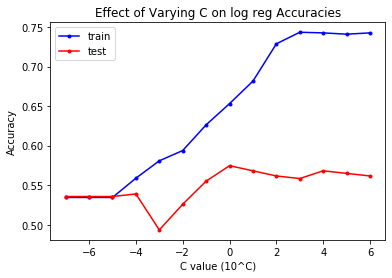

In [77]:
# plotting train vs valiadation accuracies over several C values.
# SCALED
C_values = [0.0000001, 0.000001,0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
train_accuracies = []
val_accuracies = []

for c in C_values:
    
    my_logreg = LogisticRegression(solver = 'lbfgs', max_iter=10000, C = c)
    my_logreg.fit(X_train_scaled, y_train)
    
    train_acc = my_logreg.score(X_train_scaled, y_train)
    val_acc = my_logreg.score(X_val_scaled, y_val)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
plt.figure()
plt.plot(np.log10(C_values), train_accuracies, c='blue', label='train', marker='.')
plt.plot(np.log10(C_values), val_accuracies, c='red', label='test', marker='.')
plt.title('Effect of Varying C on log reg Accuracies')
plt.xlabel('C value (10^C)')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

Our optimal C Value looks like 1. After C= 1000 the model starts to overfit heavily. We also took at the unscaled case. The results seem to be very similar. Now Let's perform a GridSearch

In [54]:
my_logreg = LogisticRegression(solver = 'lbfgs', max_iter=10000, C = 1)
my_logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
# 3. Score
print(my_logreg.score(X_train_scaled, y_train))
print(my_logreg.score(X_test_scaled, y_test))

0.6531275385865151
0.5106060606060606


Really poor performance on the test set. Let's do a gridsearch and see if we can improve our results. 

In [56]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory=cachedir)

In [57]:
# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
logreg_param_grid = [
    
    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values}
]

In [90]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   18.1s finished


In [60]:
fitted_logreg_gs.best_estimator_

Pipeline(memory='C:\\Users\\fatir\\AppData\\Local\\Temp\\tmpghz5coja',
         steps=[('scaler', None), ('dim_reducer', None),
                ('model',
                 LogisticRegression(C=0.0001, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=1, solver='lbfgs', tol=0.0001,
                                    verbose=0, warm_start=False))],
         verbose=False)

In [62]:
# Print the accuracies
print(f"The best logistic regression's accuracy on the remainder set: {fitted_logreg_gs.score(X_rem, y_rem)}")
print(f"The best logistic regression's accuracy on the test set: {fitted_logreg_gs.score(X_test, y_test)}")

The best logistic regression's accuracy on the remainder set: 0.5977907732293697
The best logistic regression's accuracy on the test set: 0.5136363636363637


Our gridsearch did not help. We are still at a 51% accuracy. Let's move on to KNN

#### KNN

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

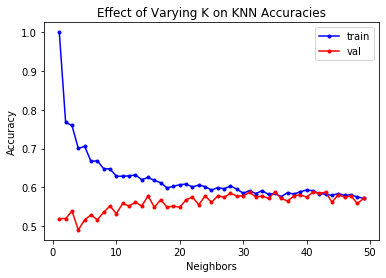

In [76]:
train_accuracies = []
validation_accuracies = []

# For multiple different tree depths
n_neighbors = range(1, 50)

for n in n_neighbors:
    
    my_knn = KNeighborsClassifier(n_neighbors=n)
    my_knn.fit(X_train_scaled, y_train)
    
    train_acc = my_knn.score(X_train_scaled, y_train)
    val_acc = my_knn.score(X_val_scaled, y_val)
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    
plt.figure()
plt.plot(n_neighbors, train_accuracies, c='blue', label='train', marker='.')
plt.plot(n_neighbors, validation_accuracies, c='red', label='val', marker='.')
plt.xlabel('Neighbors')
plt.title('Effect of Varying K on KNN Accuracies')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

In [66]:

# 1. Instantiate the model
my_knn = KNeighborsClassifier(n_neighbors=30)

# 2. Fit the model (on the training data)
my_knn.fit(X_train_scaled, y_train)

# 3. Score
print(my_knn.score(X_train_scaled, y_train))
print(my_knn.score(X_test_scaled, y_test))

0.5848903330625508
0.5363636363636364


The training set is overfit for very low values of Neighbors and overfits again after when N > 25. The optimal value seems to be K = 15 which is before the model starts overfitting. Let's run a gridsearch now to see if we can get a higher accuracy

In [91]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline_knn = Pipeline([('scaler', StandardScaler()),('dim_reducer', PCA()) , ('model', KNeighborsClassifier(n_jobs=-1))], memory=cachedir)

In [92]:
# Let's try the same range of C values from earlier
neighbors_values = range(1, 50)
weight = ['uniform','distance']
# Parameter grid
KNN_param_grid = [

    # without PCA
    {
     'model': [KNeighborsClassifier()],
     'model__n_neighbors' : neighbors_values,
     'model__weights': weight
    },
    # with PCA
    {
    'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'model': [KNeighborsClassifier()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model__n_neighbors' : neighbors_values,
     'model__weights': weight
    }
]    

In [93]:
# Instantiate the log reg grid search
KNN_gs = GridSearchCV(my_pipeline_knn, param_grid=KNN_param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fitted_KNN_gs = KNN_gs.fit(X_rem, y_rem)

Fitting 3 folds for each of 1666 candidates, totalling 4998 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 3608 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 4967 out of 4998 | elapsed:   34.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 4998 out of 4998 | elapsed:   34.8s finished


In [83]:
fitted_KNN_gs.best_estimator_

Pipeline(memory='C:\\Users\\fatir\\AppData\\Local\\Temp\\tmpdqlldow6',
         steps=[('scaler', None),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=38, p=2,
                                      weights='distance'))],
         verbose=False)

In [96]:
# Print the accuracies
print(f"The best KNN's accuracy on the remainder set: {fitted_KNN_gs.score(X_rem, y_rem)}")
print(f"The best KNN's accuracy on the test set: {fitted_KNN_gs.score(X_test, y_test)}")

The best KNN's accuracy on the remainder set: 0.9994314951677089
The best KNN's accuracy on the test set: 0.5431818181818182


We get a higher accuracy after running our grid search. This is actually our best model. We will go ahead and evaluate it.

#### KNN Evaluation

In [95]:
test_predictions = fitted_KNN_gs.predict(X_test)
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

[[ 87 118]
 [ 83 152]]
              precision    recall  f1-score   support

           0       0.51      0.42      0.46       205
           1       0.56      0.65      0.60       235

    accuracy                           0.54       440
   macro avg       0.54      0.54      0.53       440
weighted avg       0.54      0.54      0.54       440



KNN is actually our best model compared to others. Let's go ahead and evaluate the result of the classification report

- TN: There were 87 audio clips of Negative Sentiment that were correctly classified as Negative
- FP: There were 118 audio clips of Negative Sentiment were incorrectly classified as Postive
- FN: There were 83  audio clips of Positive Sentiment that were incorrectly classified as Negative
- TP: There were 152 audio clips of Positive Sentiment that were correctly classified as Positive

The accuracy really is close to 55%. This is very disappointing. The recall for the negative class is also very very low. If this model was being used in an application where identifying the negative sentiment was important it would be an very bad model.

### DCT

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

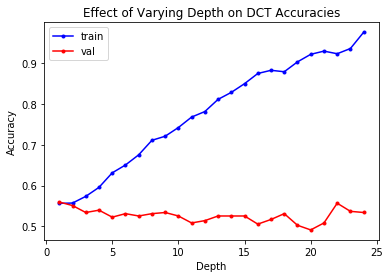

In [404]:
from sklearn.tree import DecisionTreeClassifier
# UNSCALED CASE
train_accuracies = []
val_accuracies = []

# For multiple different tree depths
max_depths = range(1, 25)

for max_depth in max_depths:

    # Instantiate the model
    DTC = DecisionTreeClassifier(max_depth=max_depth)
    
    # Fit the model
    DTC.fit(X_train, y_train)

    # Score the model
    train_accuracies.append(DTC.score(X_train, y_train))
    val_accuracies.append(DTC.score(X_val, y_val))
    
    
plt.figure()
plt.plot(max_depths, train_accuracies, c='blue', label='train', marker='.')
plt.plot(max_depths, val_accuracies, c='red', label='val', marker='.')
plt.title('Effect of Varying Depth on DCT Accuracies')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

Our Decision tree validation scores are also very low. Our model is only doing slightly better than guessing. The Optimal depth seems to be 3. We did not choose 1 or 2 as max depth because they seem to be tracking very close to each other. 

In [410]:

# 1. Instantiate the model
my_dct = DecisionTreeClassifier(max_depth=3)

# 2. Fit the model (on the training data)
my_dct.fit(X_train, y_train)

# 3. Score
print(my_dct.score(X_train, y_train))
print(my_dct.score(X_test, y_test))

0.5735607675906184
0.5431818181818182


For the most part the accuracies seem to be very similar. Looks like a depth of 3 will give us the highest accuracies without a chance of overfitting. Let's see if we can get a better results with a gridsearch

In [423]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline_dct = Pipeline([('dim_reducer', PCA()),('model', DecisionTreeClassifier())], memory=cachedir)

In [426]:
# Decision Tree's do not require scaling so we will apply no scalar here
# Parameter grid
dct_param_grid = [

# With PCA
{#'scaler':[ None], 
 'model': [DecisionTreeClassifier()],
 'dim_reducer': [PCA()],
 'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
 'model__max_depth':np.arange(1, 50)
},

# Without PCA
{#'scaler':[None], 
 'dim_reducer':[None],
 'model': [DecisionTreeClassifier()],
 'model__max_depth':np.arange(1, 50)
}
]    

In [427]:
# Instantiate the dct grid search
dct_gs = GridSearchCV(my_pipeline_dct, param_grid=dct_param_grid, cv=3, verbose=1)

# Fit the dct grid search
fitted_dct_gs = dct_gs.fit(X_rem, y_rem)

Fitting 3 folds for each of 245 candidates, totalling 735 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 735 out of 735 | elapsed:   51.3s finished


In [428]:
fitted_dct_gs.best_estimator_

Pipeline(memory='C:\\Users\\fatir\\AppData\\Local\\Temp\\tmp2_8f517n',
         steps=[('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=0.85,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [429]:
# Print the accuracies
print(f"The best decision tree's accuracy on the remainder set: {fitted_dct_gs.score(X_rem, y_rem)}")
print(f"The best decision tree's accuracy on the test set: {fitted_dct_gs.score(X_test, y_test)}")

The best decision tree's accuracy on the remainder set: 0.5821489482660602
The best decision tree's accuracy on the test set: 0.5295454545454545


53% is our best accuracy for the decision tree. Again, only slightly better than just guessing.

<a id="1D"></a>
### 1D CNN( 5 Class) (Bonus)

We ran a 1D CNN on the 5 class classification problem to see if we could improve the results as we were getting poor results otherwise

In [ ]:
# Encode the y_test because training Neural Nets requires 
y_test = pd.get_dummies(y_test)

In [ ]:
# Encode the y_rem
y_rem = pd.get_dummies(y_rem)

In [145]:
X_rem_scaled = np.expand_dims(X_rem_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)
X_rem_scaled.shape

(1539, 352, 1)

In [146]:
X_test_scaled.shape

(660, 352, 1)

In [147]:
y_test

,0.0,1.0,2.0,3.0,4.0
829,1,0,0,0,0
1989,1,0,0,0,0
998,0,1,0,0,0
631,0,0,0,1,0
1781,0,0,0,0,1
...,...,...,...,...,...
464,0,1,0,0,0
220,0,0,0,1,0
1149,0,0,1,0,0
1959,0,0,0,0,1


In [148]:
# This particular model architecture has worked for other individuals who were running a 1D CNN on MFCC values. It is NOT my own

model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_rem_scaled.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(5)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 352, 256)          2304      
_________________________________________________________________
activation_45 (Activation)   (None, 352, 256)          0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 352, 256)          524544    
_________________________________________________________________
batch_normalization_10 (Batc (None, 352, 256)          1024      
_________________________________________________________________
activation_46 (Activation)   (None, 352, 256)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 352, 256)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 44, 256)          

In [149]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model_history=model.fit(X_rem_scaled, y_rem, batch_size=16, epochs=100, validation_data=(X_test_scaled, y_test))

Epoch 1/100
97/97 [==============================] - 18s 183ms/step - loss: 1.6628 - accuracy: 0.2183 - val_loss: 1.6266 - val_accuracy: 0.2121
Epoch 2/100
97/97 [==============================] - 18s 183ms/step - loss: 1.6132 - accuracy: 0.2281 - val_loss: 1.7038 - val_accuracy: 0.2485
Epoch 3/100
97/97 [==============================] - 18s 184ms/step - loss: 1.6158 - accuracy: 0.2326 - val_loss: 1.5958 - val_accuracy: 0.2333
Epoch 4/100
97/97 [==============================] - 19s 197ms/step - loss: 1.6088 - accuracy: 0.2378 - val_loss: 1.6445 - val_accuracy: 0.2515
Epoch 5/100
97/97 [==============================] - 19s 191ms/step - loss: 1.6087 - accuracy: 0.2450 - val_loss: 1.6030 - val_accuracy: 0.2394
Epoch 6/100
97/97 [==============================] - 19s 201ms/step - loss: 1.6081 - accuracy: 0.2450 - val_loss: 1.6086 - val_accuracy: 0.2152
Epoch 7/100
97/97 [==============================] - 18s 188ms/step - loss: 1.6057 - accuracy: 0.2528 - val_loss: 1.6052 - val_accuracy:

KeyboardInterrupt: 

##### Using 1D CNN's did not help our cause either. We seem to be stuck at 25% 

In [18]:
pd.set_option('display.max_colwidth', -1)

<a id="textmodel"></a>
## Text Data Modeling

Let's call in our cleaned up text and sentiment dataframes

In [63]:
# Check sentiement dataframe. We now have to combine this with the sentiment labels
sentiment

,index,sentiment
0,190,2.4
1,199,-1.2
2,200,-0.5
3,201,2.2
4,202,1.8
...,...,...
2194,2134,-2.2
2195,2135,1.0
2196,2136,1.0
2197,2137,-1.0


In [64]:
# Reset our text data index
text2 = text2.reset_index()
text2.drop(columns = ['index'], inplace = True)
text2

,review
0,ANYHOW IT WAS REALLY GOOD
1,THERE IS SAD PART
2,A LOT OF SAD PARTS
3,BUT IT WAS REALLY REALLY AWESOME
4,AND ITS A REALLY FUNNY
...,...
2194,BUT I JUST WASNT I JUST I DONT KNOW I DIDNT REALLY LIKE THE MOVIE ALL THAT MUCH
2195,I MEAN I HAD SOME SOME GOOD MOMENTS
2196,AND A FEW FUNNY PARTS
2197,BUT ALL IN ALL I JUST THOUGHT IT WAS REALLY OVER OVERLY SAD


In [65]:
sentiment = sentiment.reset_index()

In [68]:
sentiment.drop(columns = ['index'], inplace = True)

In [69]:
sentiment

,sentiment
0,2.4
1,-1.2
2,-0.5
3,2.2
4,1.8
...,...
2194,-2.2
2195,1.0
2196,1.0
2197,-1.0


In [119]:
# Concat text and sentiment Data Frames
t_df = pd.concat([text2,sentiment], axis=1)
t_df

,review,sentiment
0,ANYHOW IT WAS REALLY GOOD,2.4
1,THERE IS SAD PART,-1.2
2,A LOT OF SAD PARTS,-0.5
3,BUT IT WAS REALLY REALLY AWESOME,2.2
4,AND ITS A REALLY FUNNY,1.8
...,...,...
2194,BUT I JUST WASNT I JUST I DONT KNOW I DIDNT REALLY LIKE THE MOVIE ALL THAT MUCH,-2.2
2195,I MEAN I HAD SOME SOME GOOD MOMENTS,1.0
2196,AND A FEW FUNNY PARTS,1.0
2197,BUT ALL IN ALL I JUST THOUGHT IT WAS REALLY OVER OVERLY SAD,-1.0


Another little step we want to use for the cleaning of our data is looking at the most commonly occurring words and seeing if they make any sense. We can do this using word clouds to check the most commonly occurring words and see if they make sense for the sentiment analysis. If they do not, let's add to them to the list of our stop words for our bag of words model

In [151]:
import nltk
# Let's add some stop words that we think are needed. 
stopwords = nltk.corpus.stopwords.words('english')

In [141]:
# Let's make a seperate variable for a word cloud
wcld = t_df["review"]

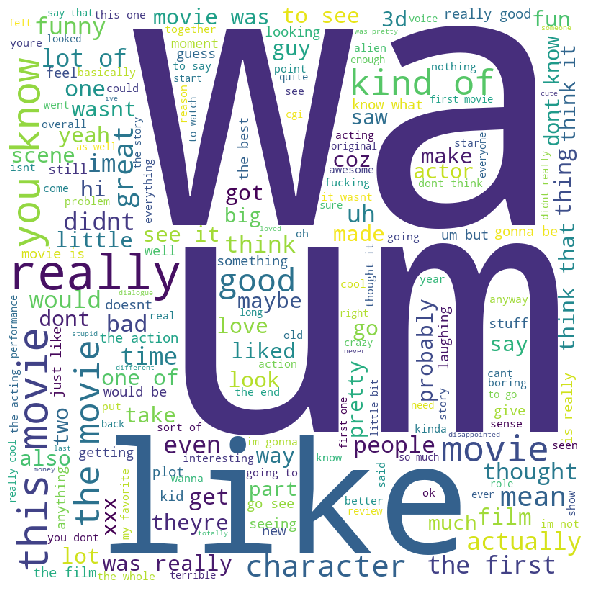

In [152]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS

comment_words = '' 
stopwords = stopwords
  
# iterate through the csv file 
for val in wcld: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

2 words here clearly don't belong. Removing words like Um and Wa might have improved our model. We will do this in the future.

In [153]:
X = t_df["review"]
y = t_df["sentiment"]

#### Binary Classification

In [154]:
# All values above 0 belong to the 1(positive) class.  All values below 0 belong to the 0(negative) class
y= np.where(y >= 0, 1,0)

In [155]:
y

array([1, 0, 0, ..., 1, 0, 0])

#### 5 Class Classification

In [430]:
# First Let's round y to the nearest integer
y =round(y)

In [431]:
# convert to a 5 class classification by labelling all -3(highly negative) and -2(negative) class as 0. -1(Weakly negative) as
# 1. 0(neutral) as 2. 1(weakly positive) as 3. Lastly, 2(positive) and 3(highly positive) will be labelled  as 4.
y = y.replace({-3: 0, -2: 0, -1:1, 0:2, -0:2, 1:3, 2:4, 3:4})

In [432]:
# Sanity Check
y

0       4.0
1       1.0
2       1.0
3       0.0
4       2.0
       ... 
2194    3.0
2195    4.0
2196    1.0
2197    2.0
2198    2.0
Name: sentiment, Length: 2199, dtype: float64

### ------------------------------------------------------------------------------------------------------------------------------------------

<a id="textmodel"></a>
## Text Data Modeling

In [182]:
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [166]:
# Examine the shapes
X_rem.shape

(1759,)

In [167]:
y_rem.shape

(1759,)

#### Bag of Words

In [183]:
# 1. Instantiate. USe englisg stop words. And set min_df =3
bagofwords = CountVectorizer(stop_words="english", min_df=3)

# 2. Fit 
bagofwords.fit(X_rem)

# 3. Transform
X_rem = bagofwords.transform(X_rem)
X_test = bagofwords.transform(X_test)
X_rem

<1759x631 sparse matrix of type '<class 'numpy.int64'>'
	with 7192 stored elements in Compressed Sparse Row format>

#### ------------------------------------------------------------------------------------------------------------------------------------------------

#### TF - IDF Bench  -- Second form of vectorization

In [104]:
# Instantiate stemmer
stemmer = nltk.stem.PorterStemmer()

In [105]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    
#    for punctuation_mark in string.punctuation:
#        # Remove punctuation and set to lower case
#        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
tfidf = TfidfVectorizer(min_df=2, tokenizer=my_tokenizer, ngram_range = (1,3))
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

#### -------------------------------------------------------------------------------------------------------------------------------------------

In [184]:
X_rem=X_rem.todense()

In [185]:
X_test=X_test.todense()

In [173]:
# these are now the features, they are the individual tokens. We could also get features for TF_IDF.
bagofwords.get_feature_names()

['3d',
 'absolutely',
 'act',
 'acting',
 'action',
 'actor',
 'actors',
 'actual',
 'actually',
 'add',
 'added',
 'admit',
 'age',
 'ago',
 'ahead',
 'aliens',
 'amazing',
 'america',
 'animated',
 'animation',
 'annoying',
 'anyways',
 'apart',
 'appreciate',
 'arent',
 'asleep',
 'ass',
 'attached',
 'attention',
 'audience',
 'average',
 'away',
 'awesome',
 'awkward',
 'bad',
 'based',
 'basically',
 'battle',
 'beautiful',
 'beginning',
 'believe',
 'benefits',
 'best',
 'better',
 'big',
 'bit',
 'black',
 'blah',
 'blown',
 'blue',
 'book',
 'bored',
 'boring',
 'boy',
 'brand',
 'bright',
 'bring',
 'brother',
 'brothers',
 'brought',
 'bunch',
 'buy',
 'called',
 'came',
 'car',
 'care',
 'cartoon',
 'case',
 'cast',
 'catherine',
 'cause',
 'certainly',
 'cgi',
 'character',
 'characters',
 'charlotte',
 'charm',
 'check',
 'cheesy',
 'cheezy',
 'chick',
 'child',
 'children',
 'chris',
 'cinema',
 'cinematography',
 'come',
 'comedy',
 'comes',
 'comic',
 'coming',
 'comme

In [187]:
my_df = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_rem)
display(my_df)

,3d,absolutely,act,acting,action,actor,actors,actual,actually,add,...,yeah,year,years,yes,youll,young,youre,youve,zach,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bench for PCA on Text Data

In [458]:
my_pca = PCA(n_components=298)
my_pca.fit(X_train)

# transform data onto the first two principal components
X_train_PCA = my_pca.transform(X_train)

# Transform test data, with PCA fit on trainign data!!!
X_test_PCA = my_pca.transform(X_test)

In [447]:
# extracting variance ratio 
expl_var = my_pca.explained_variance_ratio_
print(expl_var)

[4.78059500e-02 3.95707966e-02 3.05809358e-02 ... 1.42879854e-35
 6.59691015e-36 5.47040161e-37]


In [454]:
expl_var_cumulative = my_pca.explained_variance_ratio_.cumsum()
pd.DataFrame(expl_var_cumulative).iloc[280:300]

,0
280,0.786922
281,0.787673
282,0.788421
283,0.789168
284,0.789912
285,0.790654
286,0.791391
287,0.792122
288,0.792851
289,0.793578


In [459]:
logreg = LogisticRegression(C=1,solver='liblinear', max_iter = 10000)
logreg.fit(X_train_PCA, y_train)
# Training score with PCA
logreg.score(X_train_PCA,y_train)

0.8065173116089613

In [460]:
# Test Score with PCA
logreg.score(X_test_PCA,y_test)

0.6666666666666666

## Modeling

#### Logistic Regression

In [188]:
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.33, random_state=42, stratify=y_rem)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

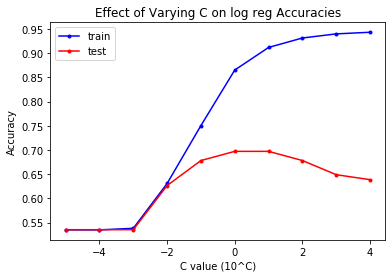

In [192]:
# Here we do some initial Hyper parameter optimization before running our gridsearch

C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train_accuracies = []
val_accuracies = []

for c in C_values:
    
    my_logreg = LogisticRegression(solver = 'lbfgs', max_iter=10000, C = c)
    my_logreg.fit(X_train, y_train)
    
    train_acc = my_logreg.score(X_train, y_train)
    val_acc = my_logreg.score(X_val, y_val)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
plt.figure()
plt.plot(np.log10(C_values), train_accuracies, c='blue', label='train', marker='.')
plt.plot(np.log10(C_values), val_accuracies, c='red', label='test', marker='.')
plt.title('Effect of Varying C on log reg Accuracies')
plt.xlabel('C value (10^C)')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

Looks like C=1 is the optimal value for the logistic regression. When C>100 the model appears to overfit to the train set

#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [193]:
logreg = LogisticRegression(C=1,solver='liblinear', max_iter = 10000)
logreg.fit(X_train, y_train)
# Training score
logreg.score(X_train,y_train)

0.865025466893039

In [194]:
# Test Score
logreg.score(X_test,y_test)

0.6954545454545454

In [196]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LogisticRegression())], memory=cachedir)

In [197]:
# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
logreg_param_grid = [
    
    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values}
]

In [199]:
# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 1746 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   35.1s finished


In [200]:
# Print the accuracies
print(f"The best logistic regession's accuracy on the remainder set: {fitted_logreg_gs.score(X_rem, y_rem)}")
print(f"The best logistic regession's accuracy on the test set: {fitted_logreg_gs.score(X_test, y_test)}")

The best logistic regession's accuracy on the remainder set: 0.8408186469584992
The best logistic regession's accuracy on the test set: 0.6931818181818182


In [201]:
from sklearn.metrics import confusion_matrix

y_pred = fitted_logreg_gs.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[122,  83],
       [ 52, 183]], dtype=int64)

In [202]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.70      0.60      0.64       205
           1       0.69      0.78      0.73       235

    accuracy                           0.69       440
   macro avg       0.69      0.69      0.69       440
weighted avg       0.69      0.69      0.69       440



- TN: There were 122 audio clips of Negative Sentiment that were correctly classified as Negative
- FP: There were 83 audio clips of Negative Sentiment were incorrectly classified as Postive
- FN: There were 52  audio clips of Positive Sentiment that were incorrectly classified as Negative
- TP: There were 183 audio clips of Positive Sentiment that were correctly classified as Positive

Looks like the recall on class 1 is much higher which means that 78% of the positive class was correctly identified out of the total. This would be ideal if identifying the positive class were as essential. However, in several problems that use sentiment analysis, identifying the negative class means that we can put out fires in time. In that case, higher recall of the negative class would be of utmost importance, which means we would need to correctly identify when a sentiment is negative.


#### KNN

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

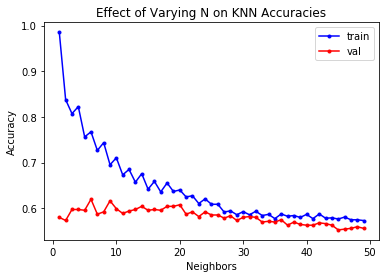

In [206]:
train_accuracies = []
validation_accuracies = []

# For multiple different tree depths
n_neighbors = range(1, 50)

for n in n_neighbors:
    
    my_knn = KNeighborsClassifier(n_neighbors=n)
    my_knn.fit(X_train, y_train)
    
    train_acc = my_knn.score(X_train, y_train)
    val_acc = my_knn.score(X_val, y_val)
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    
plt.figure()
plt.plot(n_neighbors, train_accuracies, c='blue', label='train', marker='.')
plt.plot(n_neighbors, validation_accuracies, c='red', label='val', marker='.')
plt.title('Effect of Varying N on KNN Accuracies')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

The data is clearly overfit for very low Neighbor values. Also, we don't really see any real improvement in accuracies while the Neighbors increase

In [221]:
# Testing our accuracies without hyper parameter optimization
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(X_train, y_train)
# Training score
KNN.score(X_train,y_train)

# Test Score
KNN.score(X_test,y_test)

0.5818181818181818

In [222]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline_knn = Pipeline([('scaler', StandardScaler()),('dim_reducer', PCA()) , ('model', KNeighborsClassifier(n_jobs=-1))], memory=cachedir)

In [223]:
# Let's try the same range of C values from earlier
neighbors_values = range(1, 50)
weight = ['uniform','distance']
# Parameter grid
KNN_param_grid = [

    # without PCA
    {
#    'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
#    'dim_reducer': [None],
     'model': [KNeighborsClassifier()],
     'model__n_neighbors' : neighbors_values,
     'model__weights': weight
    },
    # with PCA
    {
    'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
#    'dim_reducer': [None],
     'model': [KNeighborsClassifier()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model__n_neighbors' : neighbors_values,
     'model__weights': weight
    }
]    

In [224]:
# Instantiate the log reg grid search
KNN_gs = GridSearchCV(my_pipeline_knn, param_grid=KNN_param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fitted_KNN_gs = KNN_gs.fit(X_rem, y_rem)

Fitting 3 folds for each of 1666 candidates, totalling 4998 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4998 out of 4998 | elapsed:  7.1min finished


In [225]:
# Print the accuracies
print(f"The best KNN's accuracy on the remainder set: {fitted_KNN_gs.score(X_rem, y_rem)}")
print(f"The best KNN's accuracy on the test set: {fitted_KNN_gs.score(X_test, y_test)}")

The best KNN's accuracy on the remainder set: 0.9812393405343945
The best KNN's accuracy on the test set: 0.6545454545454545


#### Decision Tree Classifier

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

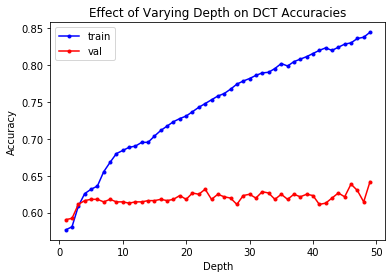

In [205]:
# UNSCALED CASE
train_accuracies = []
val_accuracies = []

# For multiple different tree depths
max_depths = range(1, 50)

for max_depth in max_depths:

    # Instantiate the model
    DTC = DecisionTreeClassifier(max_depth=max_depth)
    
    # Fit the model
    DTC.fit(X_train, y_train)

    # Score the model
    train_accuracies.append(DTC.score(X_train, y_train))
    val_accuracies.append(DTC.score(X_val, y_val))
    
    
plt.figure()
plt.plot(max_depths, train_accuracies, c='blue', label='train', marker='.')
plt.plot(max_depths, val_accuracies, c='red', label='val', marker='.')
plt.title('Effect of Varying Depth on DCT Accuracies')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

In [ ]:
# Testing our accuracies without hyper parameter optimization
DCT = DecisionTreeClassifier(max_depth = 9)
DCT.fit(X_train, y_train)
# Training score
DCT.score(X_train,y_train)

# Test Score
DCT.score(X_test,y_test)

Our Decision Tree classifier's accuracies remains fairly constant as the tree depth increases. There seems to be no highest accuracy. We'll have to look towards our Gridsearch to give us our best result

In [88]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline_dct = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()),('model', DecisionTreeClassifier())], memory=cachedir)

In [89]:
# Let's try the same range of C values from earlier

# Parameter grid
dct_param_grid = [

# With PCA
{'scaler':[StandardScaler(), None], 
 'dim_reducer':[None],
 'model': [DecisionTreeClassifier()],
 'dim_reducer': [PCA()],
 'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
 'model__max_depth':np.arange(1, 50)
},

# Without PCA
{'scaler':[StandardScaler(), None], 
 'dim_reducer':[None],
 'model': [DecisionTreeClassifier()],
 'model__max_depth':np.arange(1, 50)
}
]    

In [90]:
# Instantiate the log reg grid search
dct_gs = GridSearchCV(my_pipeline_dct, param_grid=dct_param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the log reg grid search
fitted_dct_gs = dct_gs.fit(X_rem, y_rem)

Fitting 3 folds for each of 490 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:   59.9s finished


In [92]:
# Print the accuracies
print(f"The best DCT's accuracy on the remainder set: {fitted_dct_gs.score(X_rem, y_rem)}")
print(f"The best DCT's accuracy on the test set: {fitted_dct_gs.score(X_test, y_test)}")

The best DCT's accuracy on the remainder set: 0.8397827562797013
The best DCT's accuracy on the test set: 0.6336088154269972


#### SVM(Bonus)

In [93]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline_svm = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()),('model', SVC())], memory=cachedir)

In [94]:
# Let's try the same range of C values from earlier

# Parameter grid
svm_param_grid = [

# # With PCA
# {'scaler':[StandardScaler(), None], 
#  'dim_reducer':[PCA()],
#  'model': [SVC()],
#  'dim_reducer__n_components':[1,2,3,4,5],
#  'model__C':np.power(10.0, np.arange(-3, 3)),
#  'model__kernel':['rbf','linear','sigmoid'],
#  'model__gamma':[1, 10, 100]},
# Without PCA
{'scaler':[StandardScaler(), None], 
 'model': [SVC()],
 'model__C':np.power(10.0, np.arange(-3, 3)),
 'model__kernel':['rbf','linear','sigmoid'],
 'model__gamma':[1, 10, 100]}
]    

In [95]:
# Instantiate the dct grid search
svm_gs = GridSearchCV(my_pipeline_svm, param_grid=svm_param_grid, cv=3,n_jobs=-1, verbose=1)

# Fit the dct grid search
fitted_svm_gs = svm_gs.fit(X_rem, y_rem)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  1.5min finished


In [96]:
# Print the accuracies
print(f"The best DCT's accuracy on the remainder set: {fitted_svm_gs.score(X_rem, y_rem)}")
print(f"The best DCT's accuracy on the test set: {fitted_svm_gs.score(X_test, y_test)}")

The best DCT's accuracy on the remainder set: 0.8628649015614392
The best DCT's accuracy on the test set: 0.7024793388429752


<a id="concatmodel"></a>
# Text + Audio(Concatenation)

Now comes the moment of truth. Combining the text and audio data. 

The first method we will try is the concatenation method. Here we will combine join the text and audio data into a single dataframe then perform supervised learning on it.

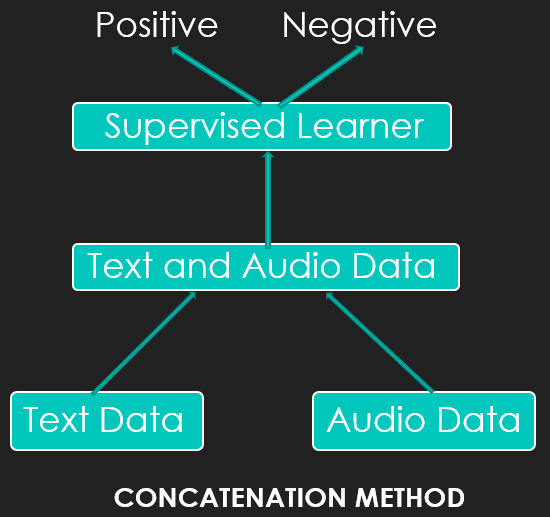

In [334]:
from IPython.display import Image
Image("Data/Capstone Images/concat.png")

In [341]:
# check the t_df dataframe. This has the text file and the sentiment 
t_df

,review,sentiment
0,ANYHOW IT WAS REALLY GOOD,2.4
1,THERE IS SAD PART,-1.2
2,A LOT OF SAD PARTS,-0.5
3,BUT IT WAS REALLY REALLY AWESOME,2.2
4,AND ITS A REALLY FUNNY,1.8
...,...,...
2194,BUT I JUST WASNT I JUST I DONT KNOW I DIDNT REALLY LIKE THE MOVIE ALL THAT MUCH,-2.2
2195,I MEAN I HAD SOME SOME GOOD MOMENTS,1.0
2196,AND A FEW FUNNY PARTS,1.0
2197,BUT ALL IN ALL I JUST THOUGHT IT WAS REALLY OVER OVERLY SAD,-1.0


In [227]:
# look at the mfcc data frame again
mfcc

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,-50.300379,-50.383061,-50.725314,-51.427882,-52.221268,-52.298492,-50.840084,-49.328397,-48.203806,-46.476463,...,-45.008132,-45.154607,-45.103449,-45.194614,-43.545242,-38.044742,-33.404765,-30.337301,-28.510144,-27.636472
1,-36.026983,-36.291206,-37.150645,-38.787734,-41.588613,-45.823580,-49.182992,-49.543512,-47.384266,-43.509514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-49.470204,-48.939091,-48.642957,-48.663554,-49.259678,-50.046580,-49.419755,-48.561246,-47.929745,-47.412296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-53.879242,-53.722571,-53.593352,-53.643235,-53.748149,-53.405391,-51.058711,-47.099215,-44.141157,-41.848321,...,-45.813412,-45.275974,-45.179930,-45.506079,-46.154899,-47.083504,-48.386144,-49.889543,-50.924124,-51.285039
4,-45.375561,-45.784450,-46.855798,-48.617616,-50.571527,-51.257761,-49.420225,-47.445893,-45.255716,-42.953839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,-31.326061,-31.522175,-32.158524,-33.261679,-34.773323,-36.445470,-37.207942,-37.268403,-37.716862,-38.420700,...,-29.923499,-30.212092,-30.630906,-31.018414,-30.895568,-28.783485,-26.977135,-25.827635,-25.167411,-24.895371
2195,-16.782538,-16.814602,-17.362150,-18.633373,-20.687419,-23.239659,-24.743586,-25.059898,-25.607429,-26.214991,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2196,-30.193318,-30.354187,-30.872850,-31.806098,-33.143447,-34.731403,-35.723044,-36.295343,-36.434593,-36.561471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2197,-26.487752,-26.701739,-27.404977,-28.741033,-30.756685,-33.232259,-34.919240,-35.219830,-35.403958,-35.248858,...,-27.570163,-27.379355,-27.464716,-27.881504,-27.024329,-24.837222,-23.386887,-22.020281,-20.994751,-20.448961


In [229]:
# Check for NaN's just for safety
mfcc.isna().sum().sum()

0

In [342]:
# combine t_df with mfcc
t_a_df = pd.concat([mfcc,t_df], axis=1)

In [343]:
# Sanity Check
t_a_df

,0,1,2,3,4,5,6,7,8,9,...,344,345,346,347,348,349,350,351,review,sentiment
0,-50.300379,-50.383061,-50.725314,-51.427882,-52.221268,-52.298492,-50.840084,-49.328397,-48.203806,-46.476463,...,-45.103449,-45.194614,-43.545242,-38.044742,-33.404765,-30.337301,-28.510144,-27.636472,ANYHOW IT WAS REALLY GOOD,2.4
1,-36.026983,-36.291206,-37.150645,-38.787734,-41.588613,-45.823580,-49.182992,-49.543512,-47.384266,-43.509514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,THERE IS SAD PART,-1.2
2,-49.470204,-48.939091,-48.642957,-48.663554,-49.259678,-50.046580,-49.419755,-48.561246,-47.929745,-47.412296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A LOT OF SAD PARTS,-0.5
3,-53.879242,-53.722571,-53.593352,-53.643235,-53.748149,-53.405391,-51.058711,-47.099215,-44.141157,-41.848321,...,-45.179930,-45.506079,-46.154899,-47.083504,-48.386144,-49.889543,-50.924124,-51.285039,BUT IT WAS REALLY REALLY AWESOME,2.2
4,-45.375561,-45.784450,-46.855798,-48.617616,-50.571527,-51.257761,-49.420225,-47.445893,-45.255716,-42.953839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AND ITS A REALLY FUNNY,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,-31.326061,-31.522175,-32.158524,-33.261679,-34.773323,-36.445470,-37.207942,-37.268403,-37.716862,-38.420700,...,-30.630906,-31.018414,-30.895568,-28.783485,-26.977135,-25.827635,-25.167411,-24.895371,BUT I JUST WASNT I JUST I DONT KNOW I DIDNT REALLY LIKE THE MOVIE ALL THAT MUCH,-2.2
2195,-16.782538,-16.814602,-17.362150,-18.633373,-20.687419,-23.239659,-24.743586,-25.059898,-25.607429,-26.214991,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,I MEAN I HAD SOME SOME GOOD MOMENTS,1.0
2196,-30.193318,-30.354187,-30.872850,-31.806098,-33.143447,-34.731403,-35.723044,-36.295343,-36.434593,-36.561471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AND A FEW FUNNY PARTS,1.0
2197,-26.487752,-26.701739,-27.404977,-28.741033,-30.756685,-33.232259,-34.919240,-35.219830,-35.403958,-35.248858,...,-27.464716,-27.881504,-27.024329,-24.837222,-23.386887,-22.020281,-20.994751,-20.448961,BUT ALL IN ALL I JUST THOUGHT IT WAS REALLY OVER OVERLY SAD,-1.0


In [347]:
# Seperate independent and dependent variables
X = t_a_df.drop(columns =['sentiment'])
y = t_a_df['sentiment']

#### Bench for Binary Classification

In [348]:
#Convert to a binary classification problem
y= np.where(y >= 0, 1,0)

In [349]:
y

array([1, 0, 0, ..., 1, 0, 0])

#### -------------------------------------------------------------------------------------------------

#### Bench for 5 class Classification

In [337]:
# First Let's round y to the nearest integer
y =round(y)

In [ ]:
# convert to a 5 class classification by labelling all -3(highly negative) and -2(negative) class as 0. -1(Weakly negative) as
# 1. 0(neutral) as 2. 1(weakly positive) as 3. Lastly, 2(positive) and 3(highly positive) will be labelled  as 4.
y = y.replace({-3: 0, -2: 0, -1:1, 0:2, -0:2, 1:3, 2:4, 3:4})

#### -------------------------------------------------------------------------------------------------

In [350]:
# We first split to remainder and test set. We can use this split for the gridsearch. but we will have to perform another split 
# for manual hyperparamter optimization
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify =y)

In [351]:
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words="english", min_df = 3)

# 2. Fit positive review data
bagofwords.fit(X_rem["review"])

# 3. Transform remainder and test set
X_rem_bg = bagofwords.transform(X_rem["review"])
X_test_bg = bagofwords.transform(X_test["review"])
X_rem_bg

<1759x631 sparse matrix of type '<class 'numpy.int64'>'
	with 7192 stored elements in Compressed Sparse Row format>

In [352]:
# Let's turn our transformed X rem into a dataframe
X_rem_bg_df = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_rem_bg.toarray())
X_rem_bg_df

,3d,absolutely,act,acting,action,actor,actors,actual,actually,add,...,yeah,year,years,yes,youll,young,youre,youve,zach,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [353]:
# do the same with our test set 
X_test_bg_df = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_test_bg.toarray())
X_test_bg_df

,3d,absolutely,act,acting,action,actor,actors,actual,actually,add,...,yeah,year,years,yes,youll,young,youre,youve,zach,zombie
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [354]:
# Now that we have count vectorized using the bag of words model we can join it with our t_df dataframe

# First let's reset our X_train 
X_rem = X_rem.reset_index()

# combine t_df with mfcc
X_rem1 = pd.concat([X_rem_bg_df, X_rem], axis=1)

In [355]:
# now let's drop our review column, we don't need it anymore
X_rem1.drop(columns = ['review'], inplace = True)

In [356]:
#Let's do the same for our train data
# First let's reset our X_train 
X_test = X_test.reset_index()

# combine t_df with mfcc
X_test1 = pd.concat([X_test_bg_df, X_test], axis=1)

In [357]:
X_test1.drop(columns = ['review'], inplace = True)

In [358]:
# Sanity check
X_rem1

,3d,absolutely,act,acting,action,actor,actors,actual,actually,add,...,342,343,344,345,346,347,348,349,350,351
0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,0,0,0,0,0,0,0,0,0,...,-47.939842,-47.995474,-48.006832,-48.047226,-47.858296,-46.041332,-43.562953,-41.473661,-40.113973,-39.465929
3,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,0,0,0,0,0,0,0,0,0,...,-24.395288,-24.237738,-24.328438,-24.466599,-24.463840,-23.971600,-22.959753,-21.913411,-21.228887,-20.940848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,0,0,0,0,0,0,0,0,0,0,...,-30.284109,-30.330305,-30.204864,-30.090005,-30.123908,-29.086087,-26.457342,-24.015277,-22.385427,-21.541230
1755,0,0,0,0,0,0,0,0,0,0,...,-27.495177,-28.156673,-28.460153,-28.862601,-27.270762,-24.385618,-22.228552,-20.519990,-19.182273,-18.490804
1756,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1757,0,0,0,0,0,0,0,0,0,0,...,-12.445756,-11.499493,-10.390369,-9.408746,-8.413534,-7.332245,-6.361229,-5.815888,-5.694990,-5.796850


In [359]:
# Sanity check
X_test1

,3d,absolutely,act,acting,action,actor,actors,actual,actually,add,...,342,343,344,345,346,347,348,349,350,351
0,0,0,0,0,1,0,0,0,0,0,...,-26.599715,-27.286188,-27.926088,-27.977782,-24.274937,-19.962637,-16.628803,-14.320361,-12.939900,-12.335884
1,0,0,0,0,0,0,0,0,0,0,...,-38.173215,-37.999763,-38.068942,-38.384621,-38.837564,-39.262749,-39.620071,-39.706864,-39.780346,-39.972584
2,0,0,0,0,0,0,0,0,0,0,...,-33.883183,-33.426420,-33.021145,-32.811398,-32.828185,-33.087988,-33.580786,-34.208598,-34.909947,-35.505010
3,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0,0,0,0,0,0,0,0,0,0,...,-35.610127,-35.849776,-35.704333,-35.540843,-33.887511,-29.991580,-27.292714,-25.499289,-24.331602,-23.790705
436,0,0,0,0,0,0,0,0,0,0,...,-14.742872,-14.624059,-14.551694,-14.470066,-14.456761,-14.562888,-14.778800,-15.076836,-15.367649,-15.608593
437,0,0,0,0,0,0,0,0,0,0,...,-36.933190,-36.870730,-36.673162,-35.810936,-34.683821,-33.162288,-31.690858,-30.632578,-30.007653,-29.731791
438,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [360]:
# Instantiate Scalar
scaler = StandardScaler()

# Scale the data
scaler.fit(X_rem1)

# Transform the data
X_rem1_scaled = scaler.transform(X_rem1)
X_test1_scaled = scaler.transform(X_test1)

For our train and validation sets we will can split the scaled or the unscaled data for our initial tests.

In [361]:
# Train and validation sets without scaling
X_train, X_val, y_train, y_val = train_test_split(X_rem1, y_rem, test_size=0.2, random_state=42, stratify =y_rem)

In [362]:
# Train and validation sets with scaling
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_rem1_scaled, y_rem, test_size=0.2, random_state=42, stratify =y_rem)

Let's go on to our modelling our data. We'll first perform some manual hyperparameter optimization for testing out the different model results. Then use gridsearch to obtain our final results

### Logistic Regression

##### Unscaled Log Reg

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

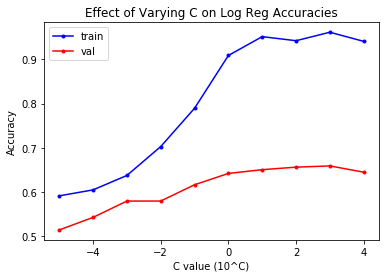

In [363]:
# Let's plot a curve of the train and validation scores as they vary with C(Unscaled)
C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train_accuracies = []
val_accuracies = []

for c in C_values:
    
    my_logreg = LogisticRegression(solver = 'lbfgs', max_iter=10000, C = c)
    my_logreg.fit(X_train, y_train)
    
    train_acc = my_logreg.score(X_train, y_train)
    val_acc = my_logreg.score(X_val, y_val)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
plt.figure()
plt.plot(np.log10(C_values), train_accuracies, c='blue', label='train', marker='.')
plt.plot(np.log10(C_values), val_accuracies, c='red', label='val', marker='.')
plt.title('Effect of Varying C on Log Reg Accuracies')
plt.xlabel('C value (10^C)')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

##### Scaled Log Reg

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

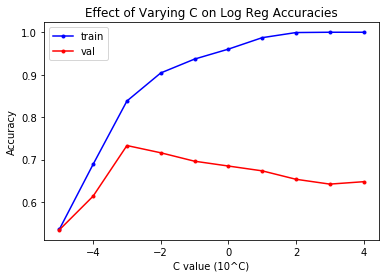

In [364]:
# Let's plot a curve of the train and validation scores as they vary with C(scaled)
C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
train_accuracies = []
val_accuracies = []

for c in C_values:
    
    my_logreg = LogisticRegression(solver = 'lbfgs', max_iter=10000, C = c)
    my_logreg.fit(X_train_scaled, y_train)
    
    train_acc = my_logreg.score(X_train_scaled, y_train)
    val_acc = my_logreg.score(X_val_scaled, y_val)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
plt.figure()
plt.plot(np.log10(C_values), train_accuracies, c='blue', label='train', marker='.')
plt.plot(np.log10(C_values), val_accuracies, c='red', label='val', marker='.')
plt.title('Effect of Varying C on Log Reg Accuracies')
plt.xlabel('C value (10^C)')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

In the 2 models we ran above we see that the scaled example gave us much higher accuracies. Our highest value for logsitic regression, in the scaled case, looks like it is around 73%. And the unscaled is around a 64%. Both scaled and unscaled cases the model seems to overfit when C>10.

This makes sense because the words are encoded as features aka 1s and 0s where are the MFCC values and much larger continuous values. Scaling reducing the differences in their values. This ensures a more "learned" model. 

In [375]:
logreg = LogisticRegression(C=0.001,solver='liblinear', max_iter = 10000)
logreg.fit(X_train_scaled, y_train)
# Training score
logreg.score(X_train_scaled,y_train)
# testing score
logreg.score(X_test1_scaled,y_test)


0.6568181818181819

66% Accuracy. A little less than what we expected. Let's move on to KNN.

### KNN

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

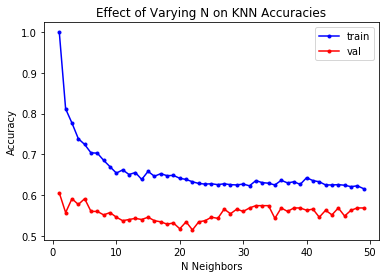

In [368]:
# Let's plot a curve of the train and validation scores as they vary with N(scaled)

train_accuracies = []
val_accuracies = []

# For multiple different tree depths
n_neighbors = range(1, 50)

for n in n_neighbors:
    
    my_knn = KNeighborsClassifier(n_neighbors=n)
    my_knn.fit(X_train_scaled, y_train)
    
    train_acc = my_knn.score(X_train_scaled, y_train)
    val_acc = my_knn.score(X_val_scaled, y_val)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
plt.figure()
plt.plot(n_neighbors, train_accuracies, c='blue', label='train', marker='.')
plt.plot(n_neighbors, val_accuracies, c='red', label='val', marker='.')
plt.title('Effect of Varying N on KNN Accuracies')
plt.xlabel('N Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

Analyzing the graph above we can see that the train set is not overfit for K > 1. 

We can see that the accuracies are around 60%. Which is very poor performance. The model also seems to overfit for Neighbors >10. This does not matter because our accuracies don't improve as N increases anyway. 

In [377]:
# Testing our accuracies without hyper parameter optimization
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(X_train_scaled, y_train)
# Training score
KNN.score(X_train_scaled,y_train)

# Test Score
KNN.score(X_test1,y_test)

0.5431818181818182

Again, on the testing score we score less than what we expected. Let's move on to decision trees

### Decision Tree

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

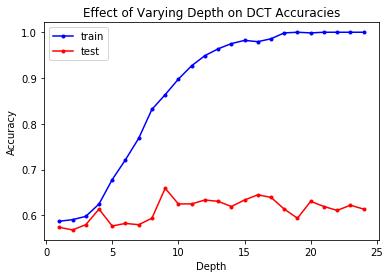

In [366]:
from sklearn.tree import DecisionTreeClassifier
# UNSCALED CASE
train_accuracies = []
val_accuracies = []

# For multiple different tree depths
max_depths = range(1, 25)

for max_depth in max_depths:

    # Instantiate the model
    DTC = DecisionTreeClassifier(max_depth=max_depth)
    
    # Fit the model
    DTC.fit(X_train, y_train)

    # Score the model
    train_accuracies.append(DTC.score(X_train, y_train))
    val_accuracies.append(DTC.score(X_val, y_val))
    
    
plt.figure()
plt.plot(max_depths, train_accuracies, c='blue', label='train', marker='.')
plt.plot(max_depths, val_accuracies, c='red', label='test', marker='.')
plt.title('Effect of Varying Depth on DCT Accuracies')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.plot

The decision tree gives us around a 66% accuracy at a depth of 9. We can say that this is the optimal depth because it has the highest accuract and is not overfit. It is also important to note that our model overfits for depth values of over 15.

In [385]:
# Testing our accuracies without hyper parameter optimization
DCT = DecisionTreeClassifier(max_depth = 9)
DCT.fit(X_train, y_train)
# Training score
DCT.score(X_train,y_train)

# Test Score
DCT.score(X_test1,y_test)

0.5977272727272728

Around a 60% Accuracy on the decision tree with a max depth of 9. Let's do some hyperparameter optimization and see if we can come up with the best results.

In [250]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()),('dim_reducer', PCA()) , ('model', RandomForestClassifier(n_jobs=-1))], memory=cachedir)

In [251]:
# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]
neighbors_values = range(1, 50)
weight = ['uniform','distance']
n_estimators = np.arange(1, 100, 10)
# Parameter grid
my_param_grid = [
    ################### RANDOM FOREST ###########################
    # Without PCA
    {'scaler':[None], 
     'model__n_estimators': n_estimators,
     'model': [RandomForestClassifier()],
     'model__n_estimators': n_estimators,
     'model__max_depth':np.arange(1, 50)
    },
    # With PCA
    {'scaler':[None],     
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [RandomForestClassifier()],
     'model__n_estimators': n_estimators,
     'model__max_depth':np.arange(1, 50)
    },
    
########################## LOGISTIC REGRESSION ###########################    
    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
########################## KNN ###########################    
    # without PCA
    {
    'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
#    'dim_reducer': [None],
     'model': [KNeighborsClassifier()],
     'model__n_neighbors' : neighbors_values,
     'model__weights': weight
    },
    # with PCA
    {
    'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
#    'dim_reducer': [None],
     'model': [KNeighborsClassifier()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model__n_neighbors' : neighbors_values,
     'model__weights': weight
    },
########################## DECISION TREE CLASSIFIER ###########################   

    # With PCA
    {'scaler':[None], 
     'model': [DecisionTreeClassifier()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model__max_depth':np.arange(1, 50)
    },

    # Without PCA
    {'scaler':[ None], 
     'dim_reducer':[None],
     'model': [DecisionTreeClassifier()],
     'model__max_depth':np.arange(1, 50)},
    
########################## SUPPORT VECTOR MACHINE ###########################   
    # # With PCA
    # {'scaler':[StandardScaler(), None], 
    #  'dim_reducer':[PCA()],
    #  'model': [SVC()],
    #  'dim_reducer__n_components':[1,2,3,4,5],
    #  'model__C':np.power(10.0, np.arange(-3, 3)),
    #  'model__kernel':['rbf','linear','sigmoid'],
    #  'model__gamma':[1, 10, 100]},
    # Without PCA
#      {'scaler':[StandardScaler(), None], 
#       'model': [SVC()],
#       'model__C':np.power(10.0, np.arange(-3, 3)),
#       'model__kernel':['rbf','linear','sigmoid'],
#       'model__gamma':[1, 10, 100]}
    
 ]

In [252]:
# Instantiate the dct grid search
my_gs = GridSearchCV( my_pipeline, param_grid=my_param_grid, cv=3,n_jobs=-1, verbose=1)

# Fit the dct grid search
fitted_my_gs = my_gs.fit(X_rem1, y_rem)

Fitting 3 folds for each of 5015 candidates, totalling 15045 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

In [253]:
fitted_my_gs.best_estimator_

Pipeline(memory='C:\\Users\\fatir\\AppData\\Local\\Temp\\tmp_hcmjt_9',
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('dim_reducer', None),
                ('model',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=1, solver='lbfgs', tol=0.0001,
                                    verbose=0, warm_start=False))],
         verbose=False)

In [254]:
# Print the accuracies
print(f"The best accuracy on the remainder set: {fitted_my_gs.score(X_rem1, y_rem)}")
print(f"The best accuracy on the test set: {fitted_my_gs.score(X_test1, y_test)}")

The best accuracy on the remainder set: 0.8487777146105742
The best accuracy on the test set: 0.7045454545454546


Our best accuracy on the test set is very similar to the score of just the text data. This makes sense because our audio data classication was only performing slight better than just guessing(around 55%). Similarly, even when we have combined the 2 datasets, the audio data does not seem to be informing the model. 

After applying gridsearch on several different models, our initial results still hold. Logistic regression gives us our best accuracy.

In [255]:
# Let's take a look at the confusion matrix

y_pred = fitted_my_gs.predict(X_test1)

confusion_matrix(y_test, y_pred)

array([[129,  76],
       [ 54, 181]], dtype=int64)

In [256]:
# Let's take a look at the classification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.70      0.63      0.66       205
           1       0.70      0.77      0.74       235

    accuracy                           0.70       440
   macro avg       0.70      0.70      0.70       440
weighted avg       0.70      0.70      0.70       440



- TN: There were 129 audio clips of Negative Sentiment that were correctly classified as Negative
- FP: There were 76 audio clips of Negative Sentiment were incorrectly classified as Postive
- FN: There were 54  audio clips of Positive Sentiment that were incorrectly classified as Negative
- TP: There were 181 audio clips of Positive Sentiment that were correctly classified as Positive

As we evaluate our model, we notice that our values in the confusion matrix and the precision and recall are strikingly similar to our models on just the text data. This again confirms our prior belief that the audio data does not inform our model much. Hopefully, the ensemble learning method will bring us better results

<a id="ensemblemodel"></a>
# Text and Audio(Ensemble learning)

For the Ensemble learning method. We put the audio and text data through supervised learning models seperately. We then use their prediction probabilities and add them together and vote based on the highest value. This determines whether an the clip was positive or negative. We've also attached an image below for illustrative purposes

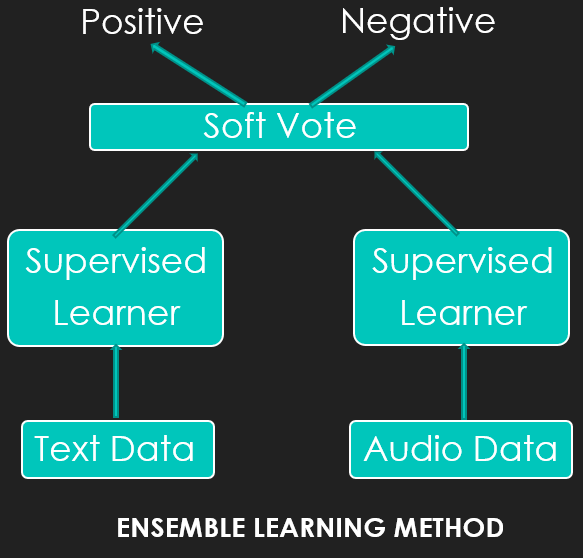

In [322]:
from IPython.display import Image
Image("Data/Capstone Images/Ensemble.png")

Now let's look at how we executed the code.

In [102]:
# We've already created a text and Audio DataFrame
t_a_df

,0,1,2,3,4,5,6,7,8,9,...,344,345,346,347,348,349,350,351,review,sentiment
0,-50.300379,-50.383061,-50.725314,-51.427882,-52.221268,-52.298492,-50.840084,-49.328397,-48.203806,-46.476463,...,-45.103449,-45.194614,-43.545242,-38.044742,-33.404765,-30.337301,-28.510144,-27.636472,ANYHOW IT WAS REALLY GOOD,2.4
1,-36.026983,-36.291206,-37.150645,-38.787734,-41.588613,-45.823580,-49.182992,-49.543512,-47.384266,-43.509514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,THERE IS SAD PART,-1.2
2,-49.470204,-48.939091,-48.642957,-48.663554,-49.259678,-50.046580,-49.419755,-48.561246,-47.929745,-47.412296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A LOT OF SAD PARTS,-0.5
3,-53.879242,-53.722571,-53.593352,-53.643235,-53.748149,-53.405391,-51.058711,-47.099215,-44.141157,-41.848321,...,-45.179930,-45.506079,-46.154899,-47.083504,-48.386144,-49.889543,-50.924124,-51.285039,BUT IT WAS REALLY REALLY AWESOME,2.2
4,-45.375561,-45.784450,-46.855798,-48.617616,-50.571527,-51.257761,-49.420225,-47.445893,-45.255716,-42.953839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AND ITS A REALLY FUNNY,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,-31.326061,-31.522175,-32.158524,-33.261679,-34.773323,-36.445470,-37.207942,-37.268403,-37.716862,-38.420700,...,-30.630906,-31.018414,-30.895568,-28.783485,-26.977135,-25.827635,-25.167411,-24.895371,BUT I JUST WASNT I JUST I DONT KNOW I DIDNT REALLY LIKE THE MOVIE ALL THAT MUCH,-2.2
2195,-16.782538,-16.814602,-17.362150,-18.633373,-20.687419,-23.239659,-24.743586,-25.059898,-25.607429,-26.214991,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,I MEAN I HAD SOME SOME GOOD MOMENTS,1.0
2196,-30.193318,-30.354187,-30.872850,-31.806098,-33.143447,-34.731403,-35.723044,-36.295343,-36.434593,-36.561471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AND A FEW FUNNY PARTS,1.0
2197,-26.487752,-26.701739,-27.404977,-28.741033,-30.756685,-33.232259,-34.919240,-35.219830,-35.403958,-35.248858,...,-27.464716,-27.881504,-27.024329,-24.837222,-23.386887,-22.020281,-20.994751,-20.448961,BUT ALL IN ALL I JUST THOUGHT IT WAS REALLY OVER OVERLY SAD,-1.0


In [257]:
# Split our dataframe into dependent and independent variables
X = t_a_df.drop(columns =['sentiment'])
y = t_a_df['sentiment']

In [258]:
y= np.where(y >= 0, 1,0)

In [296]:
# We do a train test split now because we want the same sample for our audio and text data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Later we will seperate the reviews from the MFCC values to run our results
X_train_t = X_train['review']
X_train_a = X_train.drop(columns =['review'])
# Do the same for the test set. 
X_test_t = X_test['review']
X_test_a = X_test.drop(columns =['review'])

In [297]:
# Use the bag of words vectorizer on the text data for X_train and X_test for the text data
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words="english", min_df = 3)

# 2. Fit positive review data
bagofwords.fit(X_train_t)

# 3. Transform the text data train and test set
X_train_t_bg = bagofwords.transform(X_train_t)
X_test_t_bg = bagofwords.transform(X_test_t)
X_train_t_bg

<1473x534 sparse matrix of type '<class 'numpy.int64'>'
	with 5856 stored elements in Compressed Sparse Row format>

In [298]:
# Convert our array from above into a dataframe
X_train_t_bg = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_train_t_bg.toarray())
X_train_t_bg

,3d,absolutely,act,acting,action,actor,actors,actual,actually,add,...,yeah,year,years,yes,youll,young,youre,youve,zach,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1469,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [299]:
# Convert our test array from above into a dataframe
X_test_t_bg = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_test_t_bg.toarray())
X_test_t_bg

,3d,absolutely,act,acting,action,actor,actors,actual,actually,add,...,yeah,year,years,yes,youll,young,youre,youve,zach,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
722,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
723,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [300]:
y_train

array([0, 1, 1, ..., 0, 1, 0])

As we get to the modelling stage of the ensemble learning method. We realize that there are several different combinations of models that we could apply to the text and audio data. So, to save time we decided to implement grid searches on each to find the optimal model. We can then use prediction probabilities for each of these models using a soft vote method and calculate our accuracies. 

Let's do that now.

#### Find the best Model for the TEXT DATA

In [308]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()),('dim_reducer', PCA()) , ('model', RandomForestClassifier(n_jobs=-1))], memory=cachedir)

In [309]:
# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]
neighbors_values = range(1, 50)
weight = ['uniform','distance']
n_estimators = np.arange(1, 100, 10)
# Parameter grid
my_param_grid = [
    ################### RANDOM FOREST ###########################
    # Without PCA
    {'scaler':[None], 
     'model__n_estimators': n_estimators,
     'model': [RandomForestClassifier()],
     'model__n_estimators': n_estimators,
     'model__max_depth':np.arange(1, 50)
    },
    # With PCA
    {'scaler':[None],     
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [RandomForestClassifier()],
     'model__n_estimators': n_estimators,
     'model__max_depth':np.arange(1, 50)
    },
    
########################## LOGISTIC REGRESSION ###########################    
    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
########################## KNN ###########################    
    # without PCA
    {
    'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
#    'dim_reducer': [None],
     'model': [KNeighborsClassifier()],
     'model__n_neighbors' : neighbors_values,
     'model__weights': weight
    },
    # with PCA
    {
    'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
#    'dim_reducer': [None],
     'model': [KNeighborsClassifier()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model__n_neighbors' : neighbors_values,
     'model__weights': weight
    },
########################## DECISION TREE CLASSIFIER ###########################   

    # With PCA
    {'scaler':[None], 
     'model': [DecisionTreeClassifier()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model__max_depth':np.arange(1, 50)
    },

    # Without PCA
    {'scaler':[ None], 
     'dim_reducer':[None],
     'model': [DecisionTreeClassifier()],
     'model__max_depth':np.arange(1, 50)},
    
########################## SUPPORT VECTOR MACHINE ###########################   
    # # With PCA
    # {'scaler':[StandardScaler(), None], 
    #  'dim_reducer':[PCA()],
    #  'model': [SVC()],
    #  'dim_reducer__n_components':[1,2,3,4,5],
    #  'model__C':np.power(10.0, np.arange(-3, 3)),
    #  'model__kernel':['rbf','linear','sigmoid'],
    #  'model__gamma':[1, 10, 100]},
    # Without PCA
#     {'scaler':[StandardScaler(), None], 
#      'model': [SVC()],
#      'model__C':np.power(10.0, np.arange(-3, 3)),
#      'model__kernel':['rbf','linear','sigmoid'],
#      'model__gamma':[1, 10, 100]}
    
 ]

In [310]:
# Instantiate the grid search
my_gs = GridSearchCV( my_pipeline, param_grid=my_param_grid, cv=3,n_jobs=-1, verbose=1)

# Fit the grid search for text
fitted_text_my_gs = my_gs.fit(X_train_t_bg, y_train)

Fitting 3 folds for each of 5015 candidates, totalling 15045 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 8626 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 11426 tasks      

In [311]:
# Look's like logistic regression is our best estimator
fitted_text_my_gs.best_estimator_

Pipeline(memory='C:\\Users\\fatir\\AppData\\Local\\Temp\\tmp4z6_rq0g',
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('dim_reducer', None),
                ('model',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=1, solver='lbfgs', tol=0.0001,
                                    verbose=0, warm_start=False))],
         verbose=False)

In [312]:
# Print the accuracies
print(f"The best accuracy on the text data train set: {fitted_text_my_gs.score(X_train_t_bg, y_train)}")
print(f"The best accuracy on the text data test set: {fitted_text_my_gs.score(X_test_t_bg, y_test)}")

The best accuracy on the text data train set: 0.8411405295315683
The best accuracy on the text data test set: 0.699724517906336


#### Find the best Model for the AUDIO DATA

In [270]:
# Fit the grid search for the audio data
fitted_audio_my_gs = my_gs.fit(X_train_a, y_train)

Fitting 3 folds for each of 5015 candidates, totalling 15045 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 8930 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 11808 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 15045 out of 150

In [274]:
# Looks like the random forest classifier is our best model for the audio data
fitted_audio_my_gs.best_estimator_

Pipeline(memory='C:\\Users\\fatir\\AppData\\Local\\Temp\\tmpfs8j9tj5',
         steps=[('scaler', None),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=0.8,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=3, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=91, n_jobs=None,
     

In [313]:
# Print the accuracies
print(f"The best accuracy on the audio data train set: {fitted_audio_my_gs.score(X_train_a, y_train)}")
print(f"The best accuracy on the audio data test set: {fitted_audio_my_gs.score(X_test_a, y_test)}")

The best accuracy on the audio data train set: 0.6171079429735234
The best accuracy on the audio data test set: 0.522038567493113


In [120]:
# Let's Scale the acoustic data. No need to scale the bag of words data.
# -------------------------------------

# Instantiate Scalar
scaler = StandardScaler()

# Scale the data
scaler.fit(X_train_a)

# Transform the data
X_train_a_scaled = scaler.transform(X_train_a)
X_test_a_scaled = scaler.transform(X_test_a)

In [358]:
# Iterate over the number of estimators

# Make the base estimator
#rf1 = RandomForestClassifier()
my_logreg1 = LogisticRegression(solver = 'lbfgs', max_iter=10000, C = 0.001)
my_logreg2 = LogisticRegression(solver = 'lbfgs', max_iter=10000, C = 1)
rf2 = RandomForestClassifier()

# Fit on Audio Data 
my_logreg1.fit(X_train_a_scaled, y_train)
# Fit on Text Data 
my_logreg2.fit(X_train_t_bg, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [359]:
# Audio data score for random forest
print(my_logreg1.score(X_test_a_scaled, y_test))

# text data score for random forest
print(my_logreg2.score(X_test_t_bg, y_test))

0.5413223140495868
0.7066115702479339


In [280]:
X_test_t_bg

,3d,absolutely,act,acting,action,actor,actors,actual,actually,add,...,yeah,year,years,yes,youll,young,youre,youve,zach,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
722,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
723,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [325]:
# Let's extract the prediction probabilties for text and audio data and assign them to seperate variables
preda=fitted_audio_my_gs.predict_proba(X_test_a)
predt=fitted_text_my_gs.predict_proba(X_test_t_bg)
# pred2=rf2.predict_proba(X_test_t_bg)

In [326]:
# Let's look for our array of prediction probabilities for our audio data
preda

array([[0.36691062, 0.63308938],
       [0.47009587, 0.52990413],
       [0.47633555, 0.52366445],
       ...,
       [0.48850019, 0.51149981],
       [0.33720225, 0.66279775],
       [0.51307421, 0.48692579]])

In [327]:
# Let's look for our array of prediction probabilities for our text data
predt

array([[0.40664606, 0.59335394],
       [0.21986107, 0.78013893],
       [0.09914054, 0.90085946],
       ...,
       [0.53375347, 0.46624653],
       [0.42695167, 0.57304833],
       [0.26255822, 0.73744178]])

In [328]:
# We can finally add them together
pred = preda+predt

In [321]:
# Sanity Check
pred

array([[0.77355668, 1.22644332],
       [0.68995694, 1.31004306],
       [0.57547608, 1.42452392],
       ...,
       [1.02225365, 0.97774635],
       [0.76415393, 1.23584607],
       [0.77563243, 1.22436757]])

In [330]:
# comparing the 2 accuracy score from pred
# Create a new array to append our classication onto
senti = np.array([])

# Compare each of the class 0 and 1 probabilities, choose the higher value and append to the senti array
for p in pred:
    if p[0]>p[1]:
#       print('0')
        senti = np.append(senti, 0)
    else:
#       print('1')
        senti = np.append(senti, 1)

# Here we create a new data frame with our soft vote results and the  "ground truth sentiment" from the original data
senti_df = pd.DataFrame(senti)
y_test_df = pd.DataFrame(y_test)
y_test_df['truth'] = y_test_df[0]
y_test_df.drop(columns = [0], inplace = True)
acc_df = pd.concat([senti_df, y_test_df], axis=1)

In [331]:
# Here we can see that our dataframe was created successfully
acc_df

,0,truth
0,1.0,1
1,1.0,1
2,1.0,1
3,0.0,0
4,0.0,0
...,...,...
721,1.0,0
722,1.0,0
723,0.0,1
724,1.0,0


In [332]:
# create a new column that check how our predictions did against the "ground truth sentiment"
acc_df['comp'] = np.where(acc_df[0] == acc_df["truth"], True, False)

In [333]:
# Sanity Check
acc_df

,0,truth,comp
0,1.0,1,True
1,1.0,1,True
2,1.0,1,True
3,0.0,0,True
4,0.0,0,True
...,...,...,...
721,1.0,0,False
722,1.0,0,False
723,0.0,1,False
724,1.0,0,False


In [318]:
# accuracy calculator
counter = 0
for a in acc_df['comp']:
    if (a == True):
        counter += 1
print((counter/726)*100)

68.73278236914601


Looks like we are still around 70% and model is not improving when we model the text and audio data with the ensemble learning method

# Text and Audio(Ensemble learning - Late Fusion) - FUTURE WORK

In [480]:
pred1 = pd.DataFrame(pred1)
pred2 = pd.DataFrame(pred2)
conc_pred = pd.concat([pred1, pred2], axis=1)
conc_pred

,0,1,0,1
0,0.285752,0.714248,0.385151,0.614849
1,0.185508,0.814492,0.369000,0.631000
2,0.066459,0.933541,0.040000,0.960000
3,0.637499,0.362501,0.680000,0.320000
4,0.643480,0.356520,0.875182,0.124818
...,...,...,...,...
721,0.370962,0.629038,0.192439,0.807561
722,0.281153,0.718847,0.451054,0.548946
723,0.485790,0.514210,0.406000,0.594000
724,0.405627,0.594373,0.244679,0.755321


In [491]:
# Use the bag of words vectorizer on the text data for X_train and X_test
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words="english", min_df = 3)

# 2. Fit positive review data
bagofwords.fit(X)

# 3. Transform train and test set
X_bg = bagofwords.transform(X)

# Text and Audio(Tensor Fusion Network) - FUTURE WORK